In [1]:
# importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import numpy as np
from scipy.stats import skew, kurtosis
from scipy import stats
import re


In [2]:
#Data EDA and processing
df = pd.read_csv('Car details v3.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
print("Shape:", df.shape)
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

Shape: (8128, 13)
Number of Rows: 8128
Number of Columns: 13


In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


None

In [5]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", numerical_cols)

Numerical Columns: ['year', 'selling_price', 'km_driven', 'seats']


In [6]:
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
year,8128.0,2013.804011,4.044249,1983.0,2011.0,2015.0,2017.0,2020.0
selling_price,8128.0,638271.807702,806253.403508,29999.0,254999.0,450000.0,675000.0,10000000.0
km_driven,8128.0,69819.510827,56550.554958,1.0,35000.0,60000.0,98000.0,2360457.0
seats,7907.0,5.416719,0.959588,2.0,5.0,5.0,5.0,14.0


In [7]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)

Categorical Columns: ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque']


In [8]:
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Unique values in '{col}': {df[col].unique()}")
    print(df[col].describe())


Column: name
Unique values in 'name': ['Maruti Swift Dzire VDI' 'Skoda Rapid 1.5 TDI Ambition'
 'Honda City 2017-2020 EXi' ... 'Tata Nexon 1.5 Revotorq XT'
 'Ford Freestyle Titanium Plus Diesel BSIV'
 'Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV']
count                       8128
unique                      2058
top       Maruti Swift Dzire VDI
freq                         129
Name: name, dtype: object

Column: fuel
Unique values in 'fuel': ['Diesel' 'Petrol' 'LPG' 'CNG']
count       8128
unique         4
top       Diesel
freq        4402
Name: fuel, dtype: object

Column: seller_type
Unique values in 'seller_type': ['Individual' 'Dealer' 'Trustmark Dealer']
count           8128
unique             3
top       Individual
freq            6766
Name: seller_type, dtype: object

Column: transmission
Unique values in 'transmission': ['Manual' 'Automatic']
count       8128
unique         2
top       Manual
freq        7078
Name: transmission, dtype: object

Column: owner
Unique values in 'o

In [9]:
def to_float_num(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    m = re.search(r"(\d+(\.\d+)?)", s)
    return float(m.group(1)) if m else np.nan

def parse_torque(x):

    if pd.isna(x):
        return (np.nan, np.nan)
    s = str(x).lower().replace(" ", "")
    # torque number
    torque_nm = None
    m_nm = re.search(r"(\d+(\.\d+)?)\s*nm", s)
    if m_nm:
        torque_nm = float(m_nm.group(1))
    else:
        # sometimes no 'nm' unit but still has number
        m_any = re.search(r"(\d+(\.\d+)?)", s)
        torque_nm = float(m_any.group(1)) if m_any else np.nan

    # rpm after @
    torque_rpm = np.nan
    m_rpm = re.search(r"@(\d+(\.\d+)?)", s)
    if m_rpm:
        torque_rpm = float(m_rpm.group(1))
    else:
        m_rpm2 = re.search(r"(\d+(\.\d+)?)rpm", s)
        if m_rpm2:
            torque_rpm = float(m_rpm2.group(1))

    return torque_nm, torque_rpm

def clean_car_df(df):
    df = df.copy()

    # Strip column names
    df.columns = [c.strip() for c in df.columns]

    # Standardize some object columns
    for col in ["name", "fuel", "seller_type", "transmission", "owner"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
            df[col] = df[col].replace({"nan": np.nan, "None": np.nan, "": np.nan})

    # Convert year, seats to numeric
    for col in ["year", "seats"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # selling_price, km_driven to numeric
    for col in ["selling_price", "km_driven"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # mileage: e.g., "17.0 kmpl", "23.4 km/kg"
    if "mileage" in df.columns:
        df["mileage_num"] = df["mileage"].apply(to_float_num)

    # engine: e.g., "1248 CC"
    if "engine" in df.columns:
        df["engine_cc"] = df["engine"].apply(to_float_num)

    # max_power: e.g., "74 bhp"
    if "max_power" in df.columns:
        df["max_power_bhp"] = df["max_power"].apply(to_float_num)

    # torque: create torque_nm and torque_rpm
    if "torque" in df.columns:
        torque_parsed = df["torque"].apply(parse_torque)
        df["torque_nm"] = torque_parsed.apply(lambda t: t[0])
        df["torque_rpm"] = torque_parsed.apply(lambda t: t[1])

    return df

df = clean_car_df(df)
display(df.head())

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_num,engine_cc,max_power_bhp,torque_nm,torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,23.40,1248.0,74.00,190.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,21.14,1498.0,103.52,250.0,1500.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,17.70,1497.0,78.00,12.7,2.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0,23.00,1396.0,90.00,22.4,2750.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,16.10,1298.0,88.20,11.5,4.0


In [10]:
df = df.copy()
df.drop(columns=["mileage", "engine", "max_power", "torque"], inplace=True, errors="ignore")

In [11]:
def missing_values_analysis(df):
    
    missing = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
        'Data_Type': df.dtypes
    })
    missing = missing[missing['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

    print("Missing Values Summary:")
    if len(missing) > 0:
        print(missing)
    else:
        print("No missing values found")
    
    print(f"\nTotal missing values: {df.isnull().sum().sum()}")
    print(f"Percentage of missing data: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

In [12]:
missing_values_analysis(df)

Missing Values Summary:
                      Column  Missing_Count  Missing_Percentage Data_Type
torque_rpm        torque_rpm            263            3.235728   float64
torque_nm          torque_nm            222            2.731299   float64
seats                  seats            221            2.718996   float64
mileage_num      mileage_num            221            2.718996   float64
engine_cc          engine_cc            221            2.718996   float64
max_power_bhp  max_power_bhp            216            2.657480   float64

Total missing values: 1364
Percentage of missing data: 1.20%


In [13]:
def duplicate_analysis(df):
    duplicates = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")
    print(f"Percentage of duplicates: {(duplicates / len(df)) * 100:.2f}%")
    
    if duplicates > 0:
        print("\nDuplicate Rows:")
        print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)))

In [14]:
duplicate_analysis(df)


Number of duplicate rows: 1202
Percentage of duplicates: 14.79%

Duplicate Rows:
                                      name  year  selling_price  km_driven  \
1977  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
7324  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
2129               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
7775               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
131             Audi Q5 35TDI Premium Plus  2018        3975000      31800   
...                                    ...   ...            ...        ...   
6693        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
6963        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
7862        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
145                 Volvo XC40 D4 R-Design  2018        3400000      22000   
3251                Volvo XC40 D4 R-Design  2018        3400

In [15]:
def unique_values_analysis(df):
    
    unique_info = pd.DataFrame({
        'Column': df.columns,
        'Unique_Count': [df[col].nunique() for col in df.columns],
        'Unique_Percentage': [(df[col].nunique() / len(df)) * 100 for col in df.columns],
        'Sample_Values': [df[col].unique()[:5].tolist() for col in df.columns]
    })
    
    print("\n", unique_info)
    
    # Detailed view for categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print("\n" + "-"*80)
    print("Categorical Columns - Value Counts:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())

In [16]:
unique_values_analysis(df)


            Column  Unique_Count  Unique_Percentage  \
0            name          2058          25.319882   
1            year            29           0.356791   
2   selling_price           677           8.329232   
3       km_driven           921          11.331201   
4            fuel             4           0.049213   
5     seller_type             3           0.036909   
6    transmission             2           0.024606   
7           owner             5           0.061516   
8           seats             9           0.110728   
9     mileage_num           381           4.687500   
10      engine_cc           121           1.488681   
11  max_power_bhp           319           3.924705   
12      torque_nm           244           3.001969   
13     torque_rpm            56           0.688976   

                                        Sample_Values  
0   [Maruti Swift Dzire VDI, Skoda Rapid 1.5 TDI A...  
1                      [2014, 2006, 2010, 2007, 2017]  
2            [45000


Distribution Metrics:

year:
  Skewness: -1.0721
  Kurtosis: 1.7052
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

selling_price:
  Skewness: 4.1928
  Kurtosis: 21.0676
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

km_driven:
  Skewness: 11.1688
  Kurtosis: 383.8604
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

seats:
  Skewness: 1.9695
  Kurtosis: 3.7963
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

mileage_num:
  Skewness: -0.1426
  Kurtosis: 0.5687
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

engine_cc:
  Skewness: 1.1351
  Kurtosis: 0.7313
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

max_power_bhp:
  Skewness: 1.6210
  Kurtosis: 3.7813
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

torque_nm:
  Skewness: 1.0600
  Kurtosis: 1.9366
  Shapiro-Wilk test p-value: 0.0000
  Normal distribution: No

torque_rpm:
  Skewness: 0.1320
  Kurtosis: -0.9173
  Shapiro-Wilk test p-

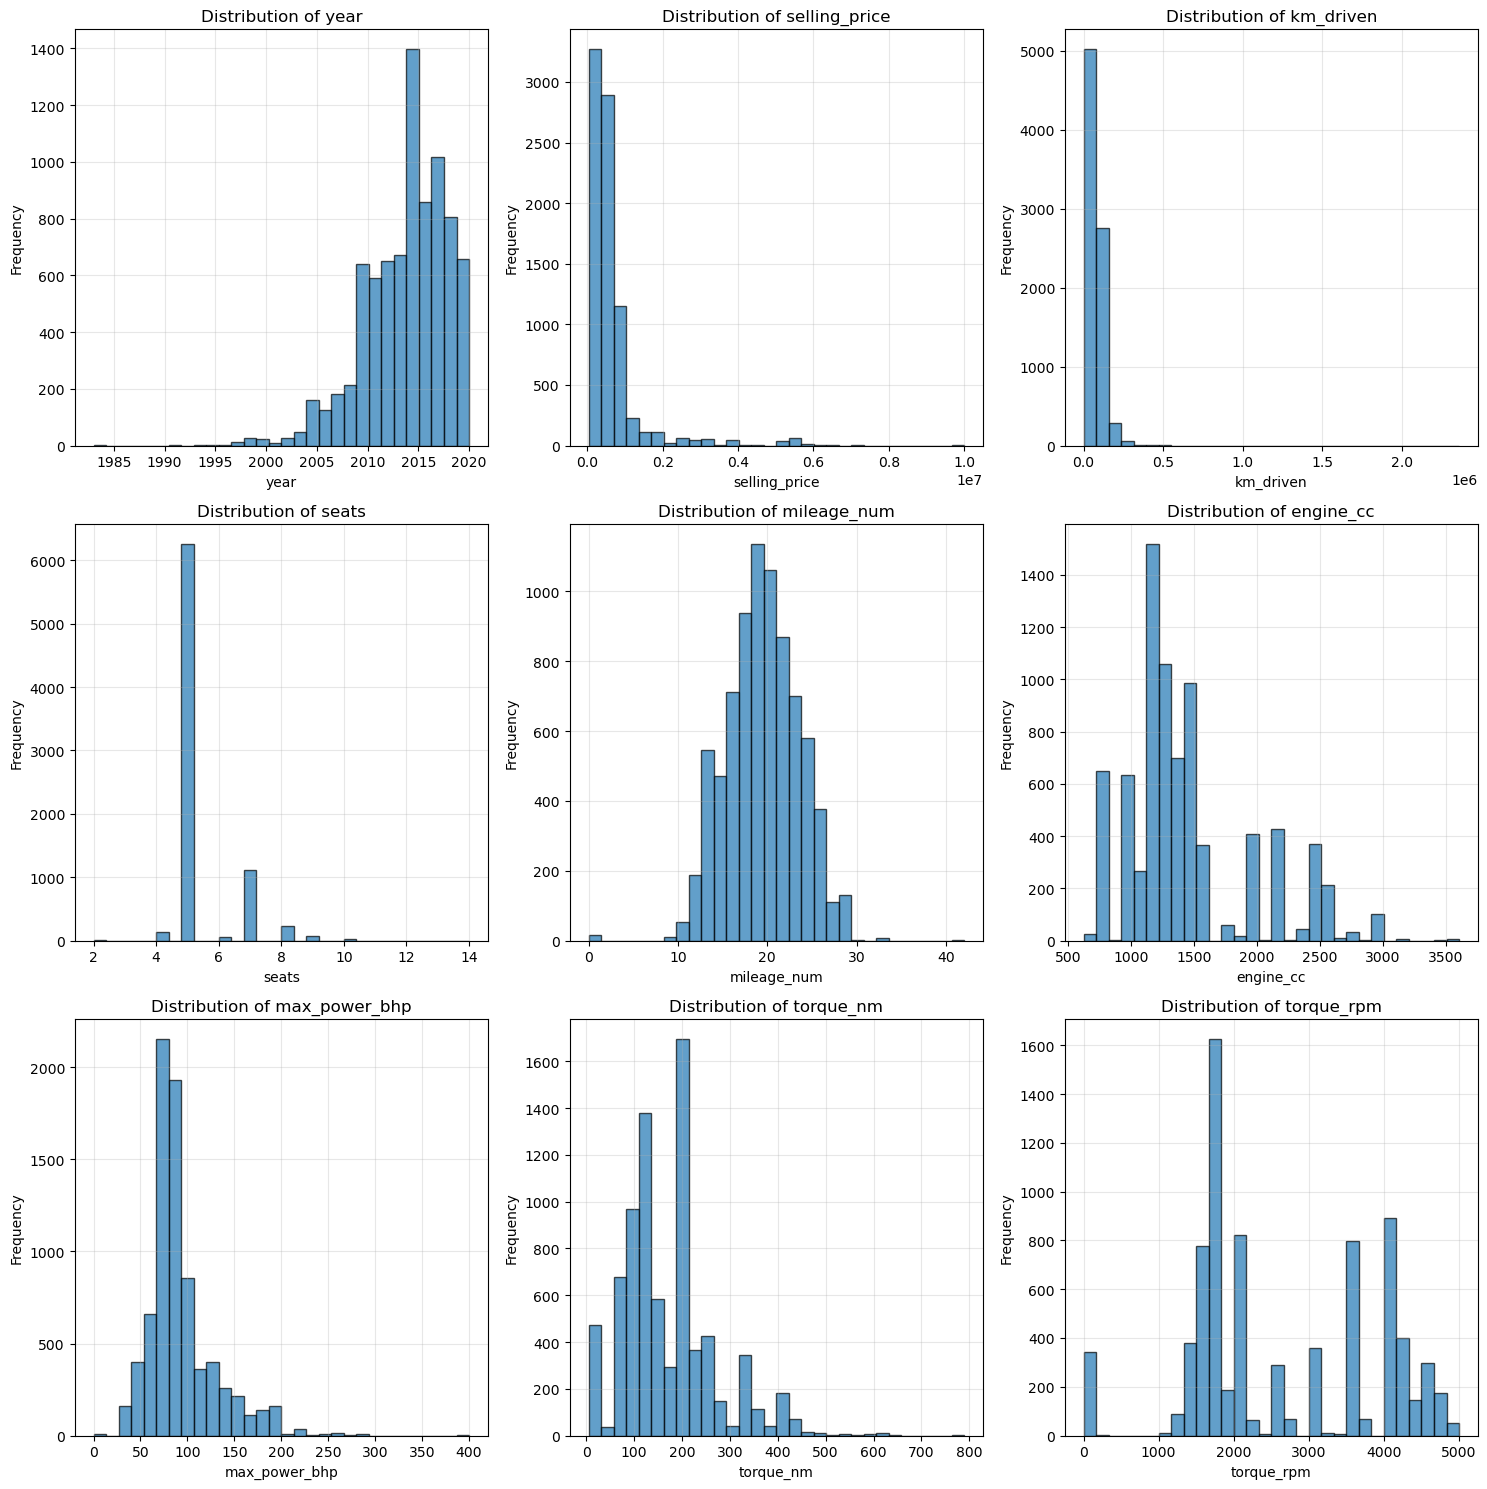

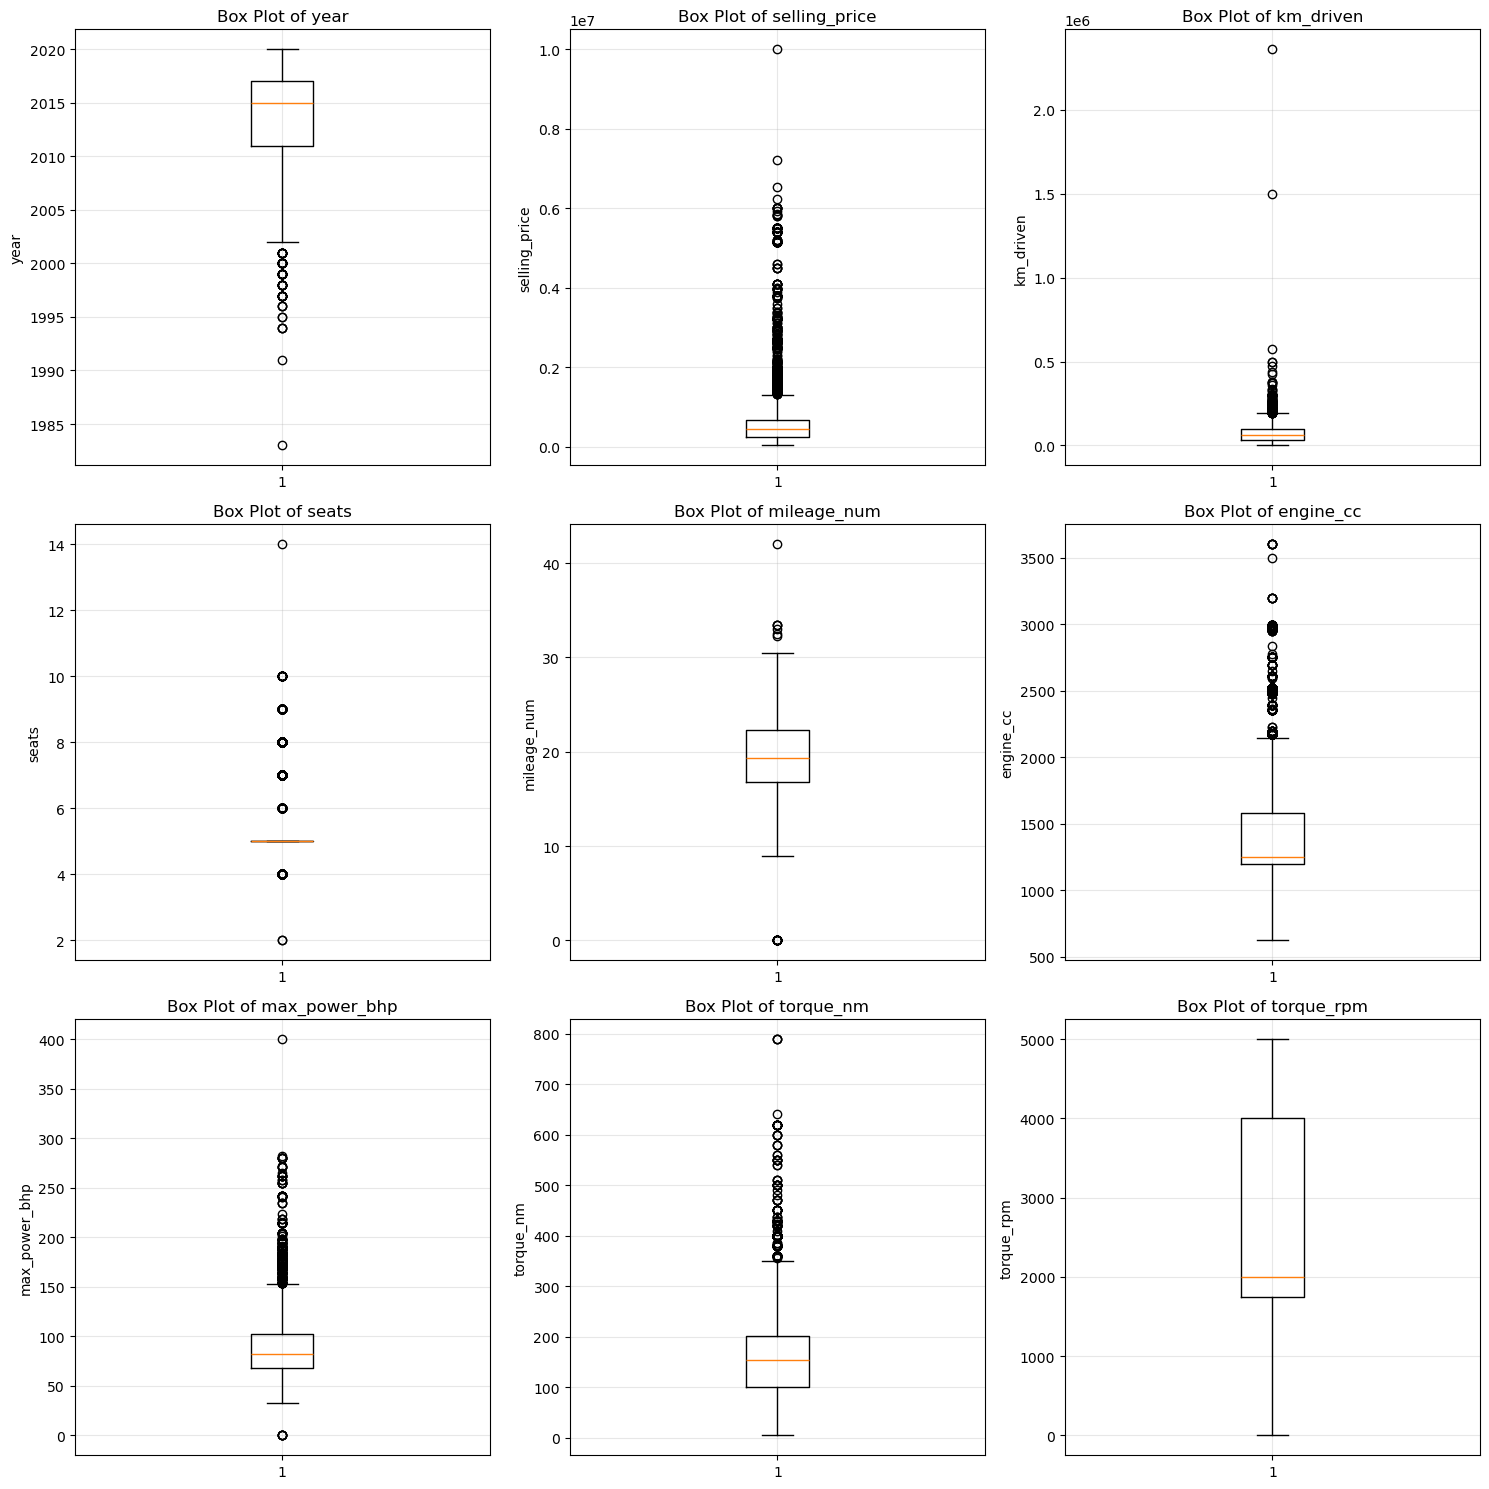

In [17]:
def distribution_analysis(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Distribution metrics
    print("\nDistribution Metrics:")
    for col in numerical_cols:
        print(f"\n{col}:")
        print(f"  Skewness: {skew(df[col].dropna()):.4f}")
        print(f"  Kurtosis: {kurtosis(df[col].dropna()):.4f}")
        
        # Normality test
        if len(df[col].dropna()) >= 3:
            stat, p_value = stats.shapiro(df[col].dropna().sample(min(5000, len(df[col].dropna()))))
            print(f"  Shapiro-Wilk test p-value: {p_value:.4f}")
            print(f"  Normal distribution: {'Yes' if p_value > 0.05 else 'No'}")
    
    # Histograms
    n_cols = len(numerical_cols)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numerical_cols):
        axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Box plots
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numerical_cols):
        axes[idx].boxplot(df[col].dropna())
        axes[idx].set_title(f'Box Plot of {col}')
        axes[idx].set_ylabel(col)
        axes[idx].grid(True, alpha=0.3)
    
    for idx in range(len(numerical_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

distribution_analysis(df)

##### Selling Price
- Highly right-skewed.
- Majority of vehicles are in lower price ranges.
- Few luxury cars create extreme high-price outliers.

**Implication:**
Log transformation may improve model performance.

##### Kilometers Driven
- Distribution shows most vehicles in mid-range mileage.
- Long tail exists for high-mileage vehicles.

**Implication:**
Higher mileage often lowers price.

##### Engine Capacity & Power
- Engine sizes cluster around common passenger vehicle ranges.
- Power distribution shows majority of cars in moderate power range.
- High-performance vehicles form outliers.

**Implication:**
Engine size and power strongly influence price.

##### Mileage Efficiency
- Mileage values vary across fuel and engine types.

**Implication:**
Higher mileage efficiency may influence resale value but not as strongly as engine power.

In [18]:
def outlier_detection(df):

    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    print("\nIQR Method (Outliers beyond 1.5 * IQR):")
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        
        print(f"\n{col}:")
        print(f"  Lower bound: {lower_bound:.2f}")
        print(f"  Upper bound: {upper_bound:.2f}")
        print(f"  Outliers count: {outlier_count}")
        print(f"  Outliers percentage: {outlier_percentage:.2f}%")
    
    print("Z-Score Method (|Z-score| > 3):")
    for col in numerical_cols:
        z_scores = np.abs(stats.zscore(df[col].dropna()))
        outliers = np.sum(z_scores > 3)
        outlier_percentage = (outliers / len(df[col].dropna())) * 100
        
        print(f"\n{col}:")
        print(f"  Outliers count: {outliers}")
        print(f"  Outliers percentage: {outlier_percentage:.2f}%")


In [19]:
outlier_detection(df)


IQR Method (Outliers beyond 1.5 * IQR):

year:
  Lower bound: 2002.00
  Upper bound: 2026.00
  Outliers count: 81
  Outliers percentage: 1.00%

selling_price:
  Lower bound: -375002.50
  Upper bound: 1305001.50
  Outliers count: 600
  Outliers percentage: 7.38%

km_driven:
  Lower bound: -59500.00
  Upper bound: 192500.00
  Outliers count: 170
  Outliers percentage: 2.09%

seats:
  Lower bound: 5.00
  Upper bound: 5.00
  Outliers count: 1653
  Outliers percentage: 20.34%

mileage_num:
  Lower bound: 8.47
  Upper bound: 30.63
  Outliers count: 24
  Outliers percentage: 0.30%

engine_cc:
  Lower bound: 619.50
  Upper bound: 2159.50
  Outliers count: 1183
  Outliers percentage: 14.55%

max_power_bhp:
  Lower bound: 17.12
  Upper bound: 152.93
  Outliers count: 570
  Outliers percentage: 7.01%

torque_nm:
  Lower bound: -50.50
  Upper bound: 353.50
  Outliers count: 404
  Outliers percentage: 4.97%

torque_rpm:
  Lower bound: -1625.00
  Upper bound: 7375.00
  Outliers count: 0
  Outliers 

In [20]:
def correlation_analysis(df):
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Pearson correlation
    print("\nPearson Correlation Matrix:")
    corr_matrix = df[numerical_cols].corr()
    print(corr_matrix)
    
    # Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
    plt.title('Correlation Heatmap (Pearson)')
    plt.tight_layout()
    plt.show()
    
    # High correlations
    print("High Correlations (|r| > 0.7):")
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature 1': corr_matrix.columns[i],
                    'Feature 2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
    
    if high_corr:
        print(pd.DataFrame(high_corr))
    else:
        print("No high correlations found.")
    
    # Spearman correlation
    print("Spearman Correlation Matrix:")
    spearman_corr = df[numerical_cols].corr(method='spearman')
    print(spearman_corr)



Pearson Correlation Matrix:
                   year  selling_price  km_driven     seats  mileage_num  \
year           1.000000       0.414092  -0.418006 -0.009144     0.329145   
selling_price  0.414092       1.000000  -0.225534  0.041358    -0.126054   
km_driven     -0.418006      -0.225534   1.000000  0.227336    -0.173073   
seats         -0.009144       0.041358   0.227336  1.000000    -0.452085   
mileage_num    0.329145      -0.126054  -0.173073 -0.452085     1.000000   
engine_cc      0.018848       0.455734   0.205914  0.610309    -0.575831   
max_power_bhp  0.226320       0.748489  -0.038075  0.191999    -0.374621   
torque_nm      0.289456       0.619792  -0.003322  0.274470    -0.171132   
torque_rpm     0.160100      -0.129067  -0.277920 -0.316882     0.091367   

               engine_cc  max_power_bhp  torque_nm  torque_rpm  
year            0.018848       0.226320   0.289456    0.160100  
selling_price   0.455734       0.748489   0.619792   -0.129067  
km_driven      

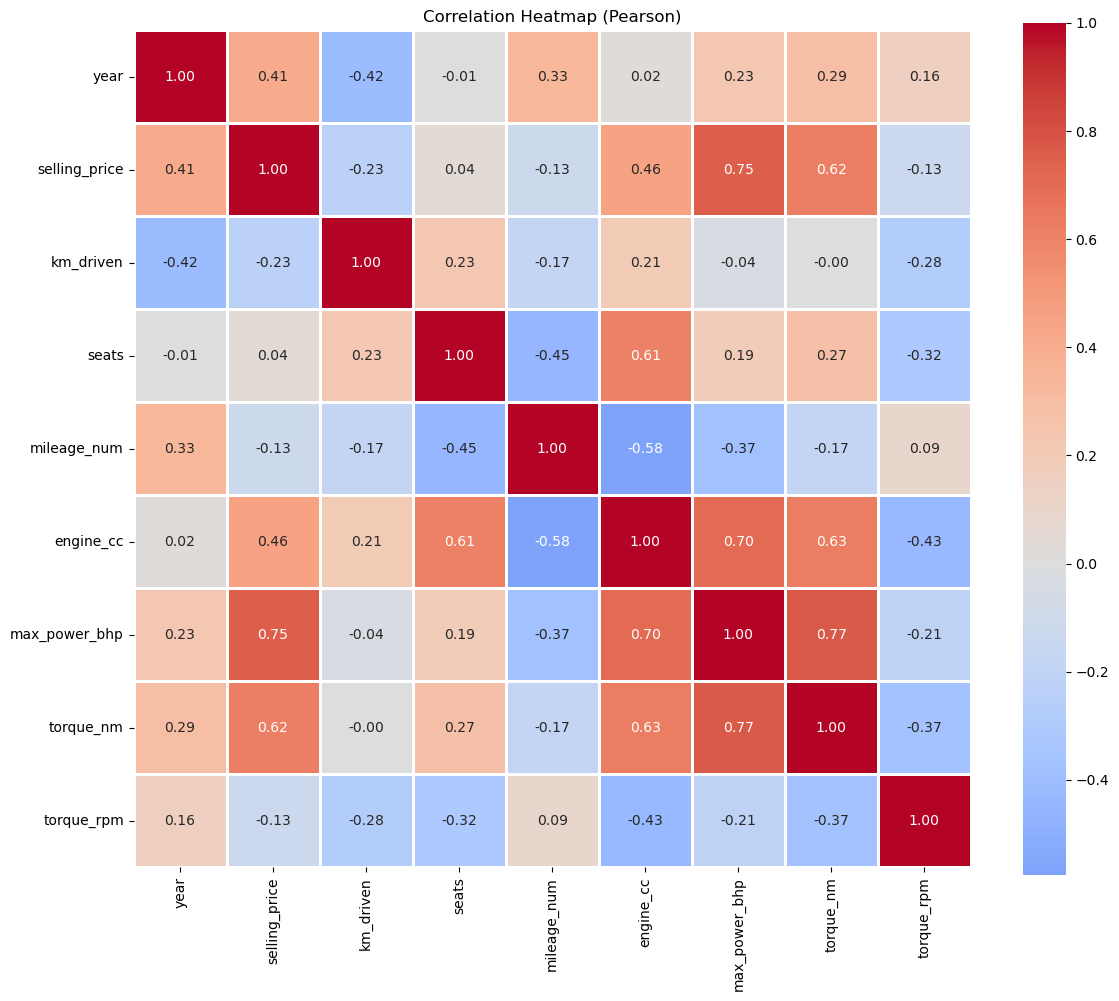

High Correlations (|r| > 0.7):
       Feature 1      Feature 2  Correlation
0  selling_price  max_power_bhp     0.748489
1      engine_cc  max_power_bhp     0.703975
2  max_power_bhp      torque_nm     0.770206
Spearman Correlation Matrix:
                   year  selling_price  km_driven     seats  mileage_num  \
year           1.000000       0.713523  -0.617792 -0.010459     0.304563   
selling_price  0.713523       1.000000  -0.355087  0.263143    -0.029221   
km_driven     -0.617792      -0.355087   1.000000  0.228042    -0.163102   
seats         -0.010459       0.263143   0.228042  1.000000    -0.439428   
mileage_num    0.304563      -0.029221  -0.163102 -0.439428     1.000000   
engine_cc     -0.002641       0.513526   0.241342  0.519604    -0.462244   
max_power_bhp  0.221098       0.670867  -0.026454  0.283206    -0.345271   
torque_nm      0.273367       0.654468   0.058213  0.346306    -0.085611   
torque_rpm     0.115627      -0.217939  -0.325789 -0.401490     0.150202   


In [21]:
correlation_analysis(df)

#### Key correlations observed:

##### Selling price strongly correlates with:

- Engine capacity
- Maximum power
- Manufacturing year

##### Negative correlation observed with:
- Kilometers driven

**Implication:**
Cars with larger engines, higher power, and newer manufacturing years tend to be priced higher.

In [22]:
def categorical_analysis(df):

    new_category_cols = ['owner', 'fuel', 'seller_type', 'transmission']
    
    # keep only columns that exist in df
    categorical_cols = [c for c in new_category_cols if c in df.columns]

    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        df[col].value_counts().plot(kind='bar', edgecolor='black', alpha=0.7)

        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

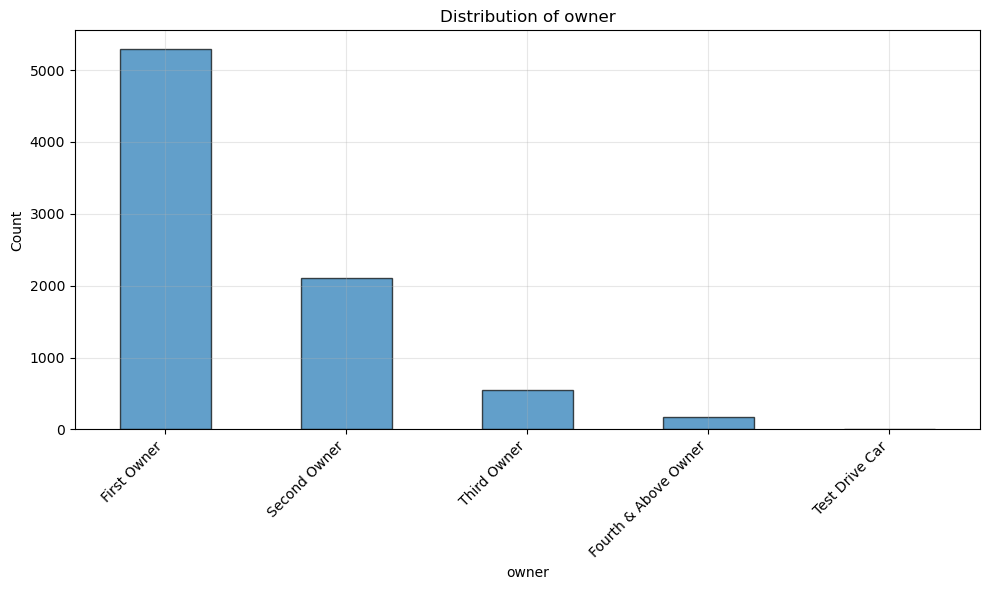

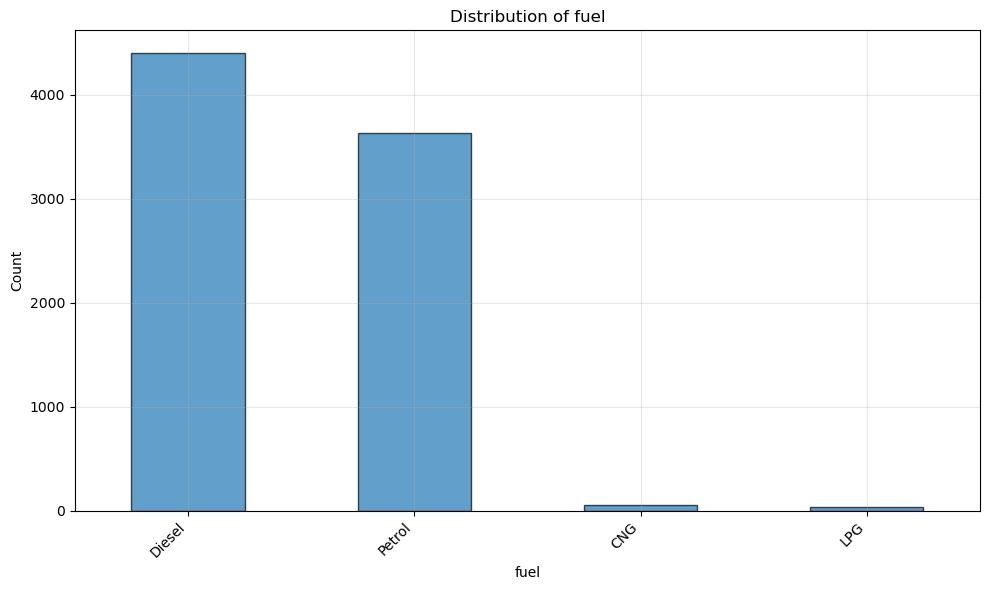

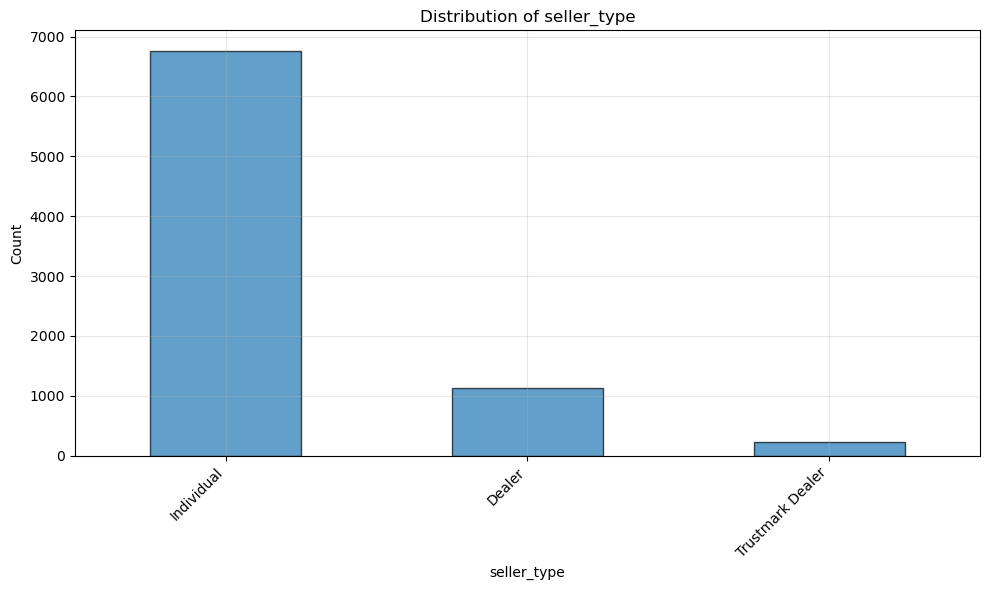

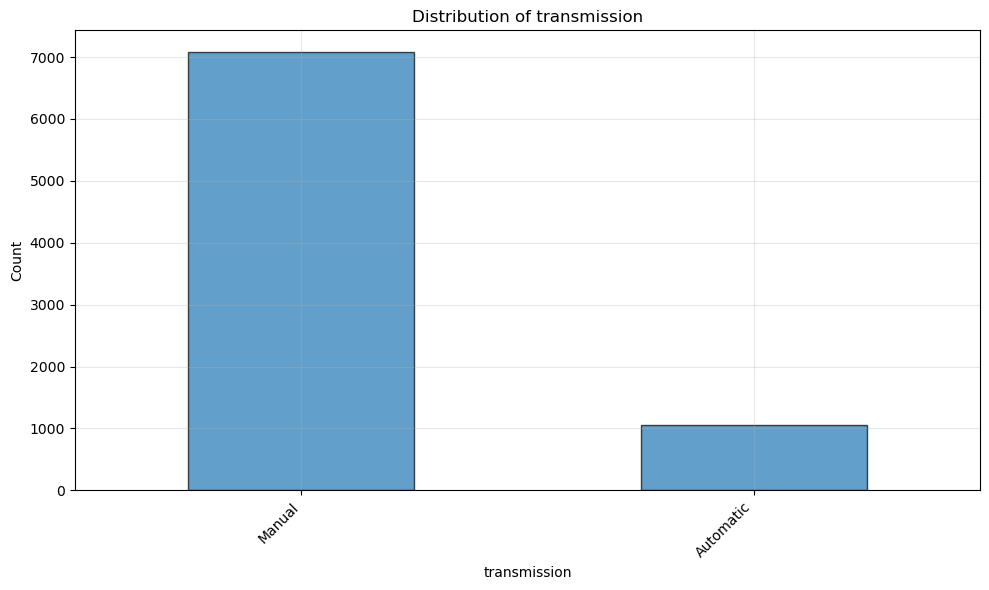

In [23]:
categorical_analysis(df)

###### Fuel Type
- Diesel and Petrol vehicles dominate the dataset.
- Alternative fuels appear less frequently.
- Price patterns vary slightly by fuel type.

##### Transmission
- Manual vehicles are more common.
- Automatic vehicles often command higher prices.

##### Ownership
- First-owner cars typically have higher resale value.
- Cars with multiple owners tend to sell cheaper.

##### Seller Type
- Dealer listings sometimes show higher prices compared to individuals.

In [24]:
def bivariate_analysis(df, target_col='selling_price'):

    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    new_category_cols = ['owner', 'fuel', 'seller_type', 'transmission']
    # keep only columns that exist in df
    categorical_cols = [c for c in new_category_cols if c in df.columns]
    
    # Numerical vs Target
    print(f"\nCorrelation with {target_col}:")
    if target_col in numerical_cols:
        correlations = df[numerical_cols].corrwith(df[target_col]).sort_values(ascending=False)
        print(correlations)
        
        # Scatter plots
        other_numerical = [col for col in numerical_cols if col != target_col]
        n_cols = len(other_numerical)
        n_rows = (n_cols + 2) // 3
        
        fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_cols > 1 else [axes]
        
        for idx, col in enumerate(other_numerical):
            axes[idx].scatter(df[col], df[target_col], alpha=0.5)
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel(target_col)
            axes[idx].set_title(f'{col} vs {target_col}')
            axes[idx].grid(True, alpha=0.3)
        
        for idx in range(len(other_numerical), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Categorical vs Target
    print(f"Categorical features vs {target_col}:")
    
    for col in categorical_cols:
        print(f"\n{col}:")
        group_stats = df.groupby(col)[target_col].agg(['mean', 'median', 'std', 'count'])
        print(group_stats)
        
        # Box plot
        plt.figure(figsize=(12, 6))
        df.boxplot(column=target_col, by=col, figsize=(12, 6))
        plt.title(f'{target_col} by {col}')
        plt.suptitle('')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


Correlation with selling_price:
selling_price    1.000000
max_power_bhp    0.748489
torque_nm        0.619792
engine_cc        0.455734
year             0.414092
seats            0.041358
mileage_num     -0.126054
torque_rpm      -0.129067
km_driven       -0.225534
dtype: float64


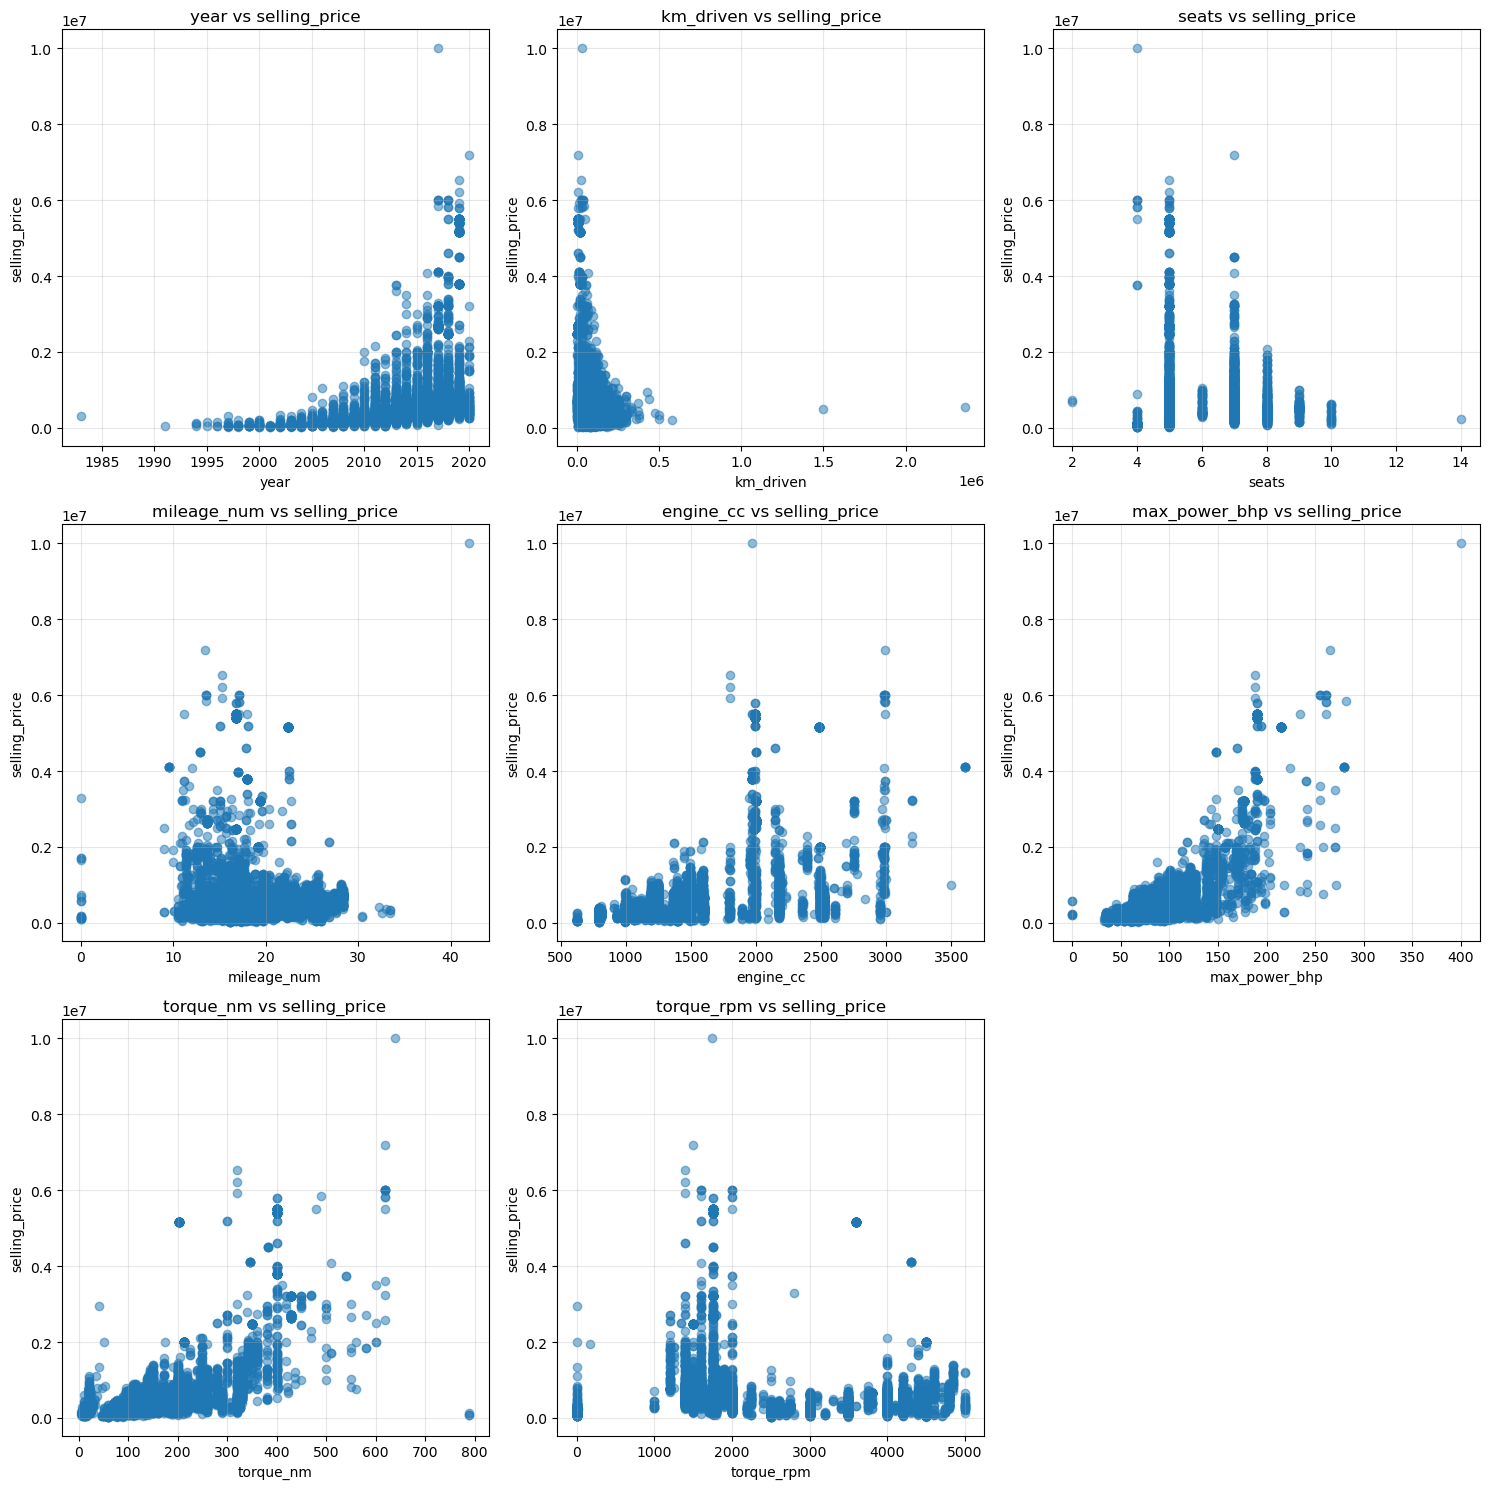

Categorical features vs selling_price:

owner:
                              mean     median           std  count
owner                                                             
First Owner           7.830864e+05   550000.0  9.319794e+05   5289
Fourth & Above Owner  2.258132e+05   170000.0  1.549900e+05    174
Second Owner          3.929645e+05   310000.0  3.264403e+05   2105
Test Drive Car        4.403800e+06  5923000.0  2.510598e+06      5
Third Owner           2.840153e+05   225000.0  2.268865e+05    555


<Figure size 1200x600 with 0 Axes>

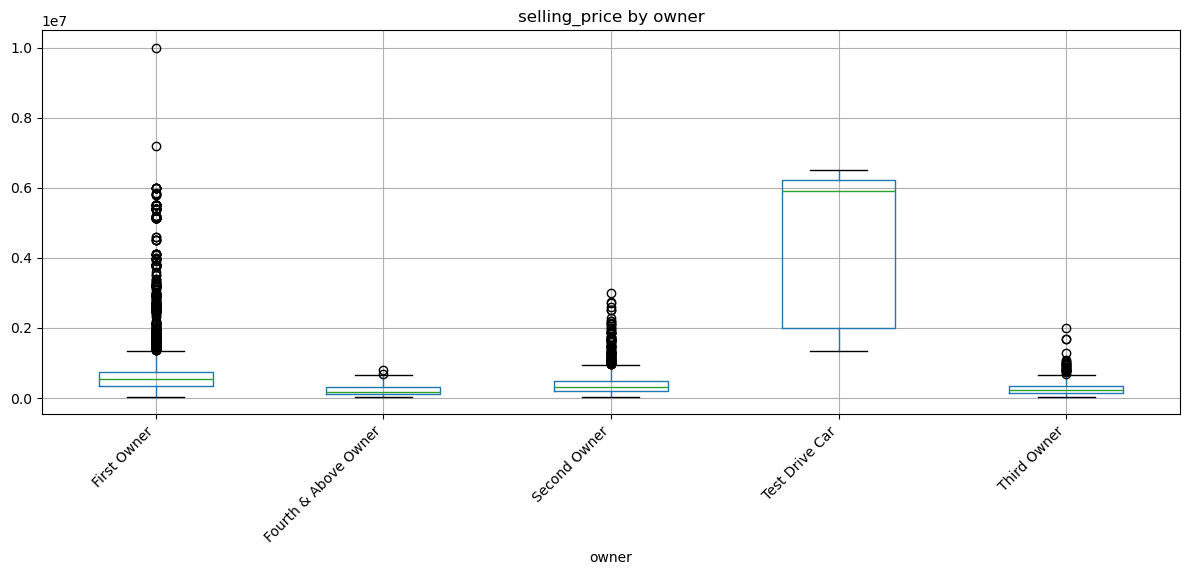


fuel:
                 mean    median            std  count
fuel                                                 
CNG     301017.491228  320000.0  111582.298949     57
Diesel  791452.921627  550000.0  908894.768774   4402
LPG     200421.052632  195500.0   84921.468199     38
Petrol  462441.061691  345000.0  624788.835690   3631


<Figure size 1200x600 with 0 Axes>

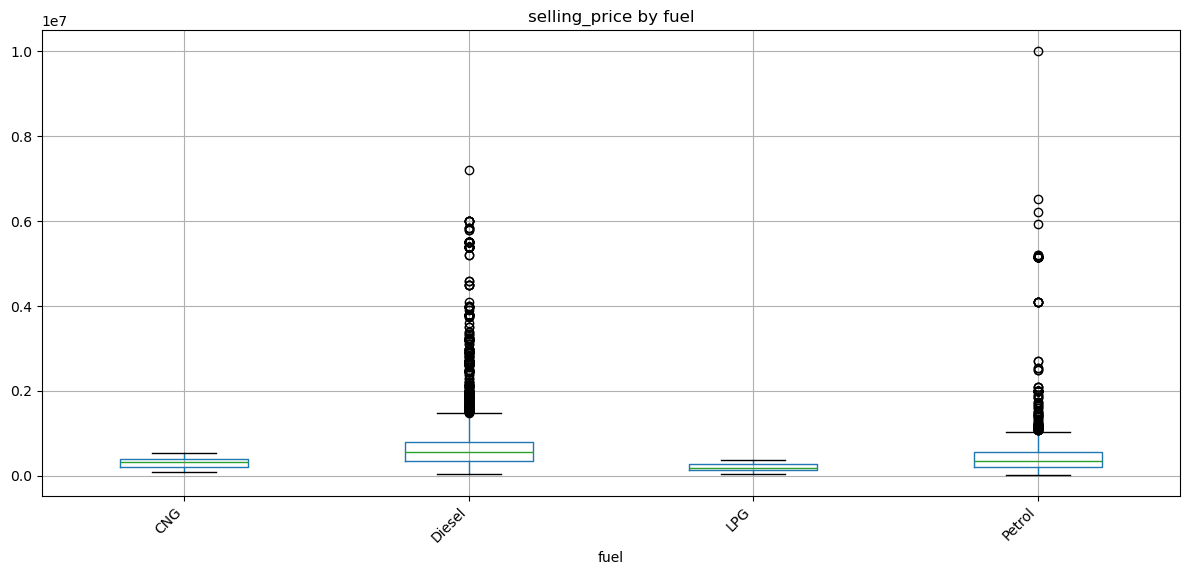


seller_type:
                          mean    median           std  count
seller_type                                                  
Dealer            1.443494e+06  690000.0  1.569286e+06   1126
Individual        4.985612e+05  400000.0  4.837797e+05   6766
Trustmark Dealer  8.018390e+05  650000.0  5.080779e+05    236


<Figure size 1200x600 with 0 Axes>

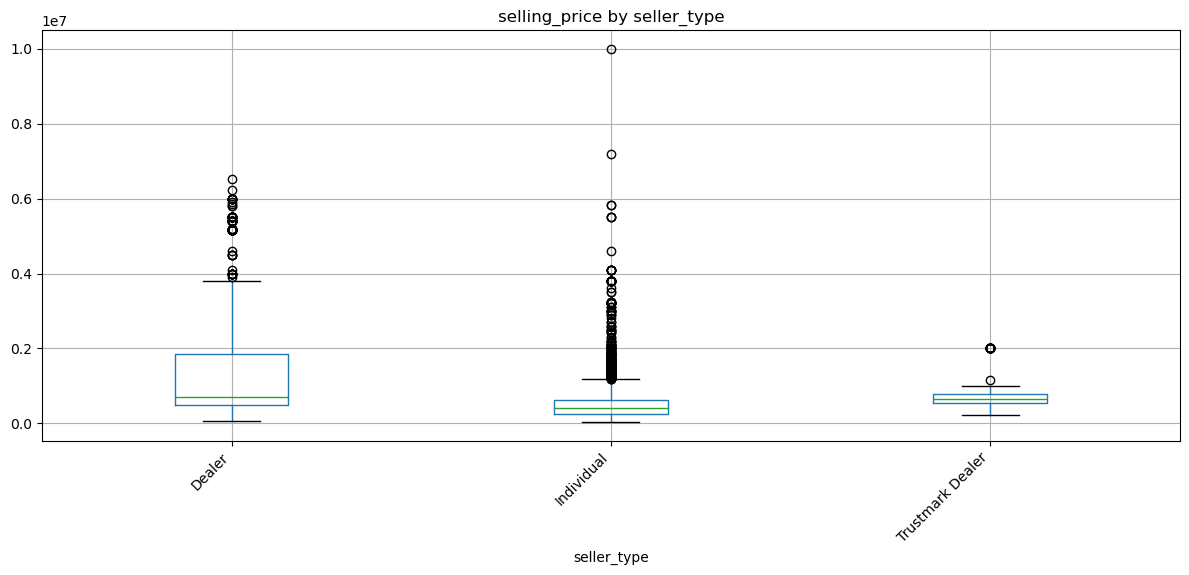


transmission:
                      mean     median           std  count
transmission                                              
Automatic     1.870828e+06  1100000.0  1.640533e+06   1050
Manual        4.554259e+05   400000.0  2.978652e+05   7078


<Figure size 1200x600 with 0 Axes>

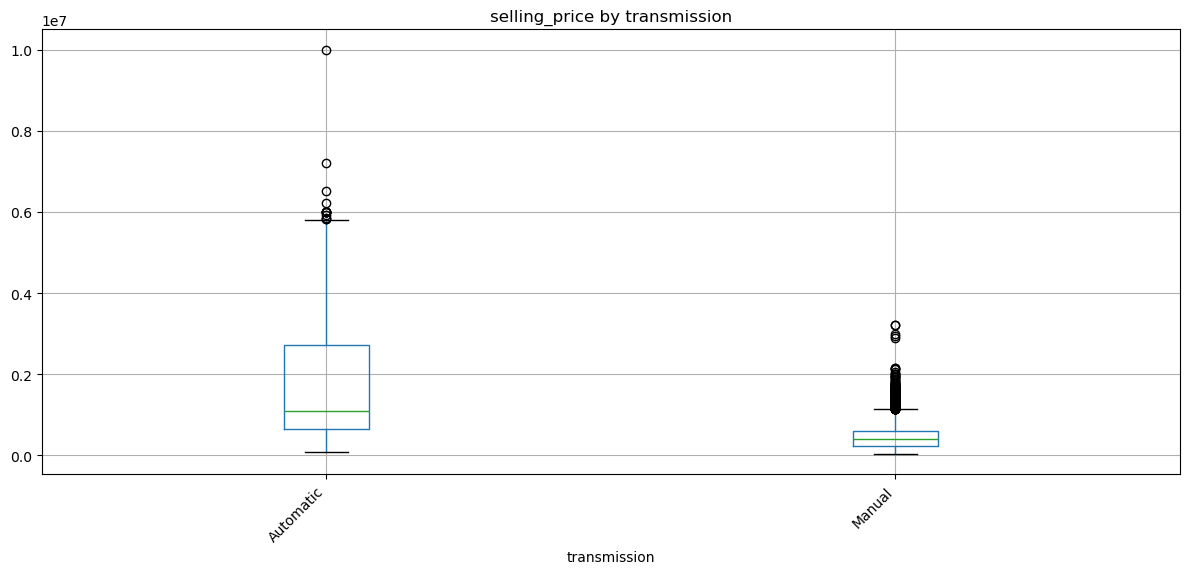

In [25]:
bivariate_analysis(df)

**Key trends:**
- Selling price decreases as kilometers driven increases.
- Price increases with engine size and power.
- Newer vehicles have significantly higher prices.
- Automatic transmission vehicles often cost more.

In [26]:
def pairplot_analysis(df, sample_size=2000):
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Sample data if too large
    if len(df) > sample_size:
        df_sample = df[numerical_cols].sample(sample_size)
        print(f"\nUsing sample of {sample_size} rows for pair plot")
    else:
        df_sample = df[numerical_cols]
    
    print("\nGenerating pair plot...")
    sns.pairplot(df_sample, diag_kind='kde', plot_kws={'alpha': 0.6})
    plt.tight_layout()
    plt.show()



Using sample of 2000 rows for pair plot

Generating pair plot...


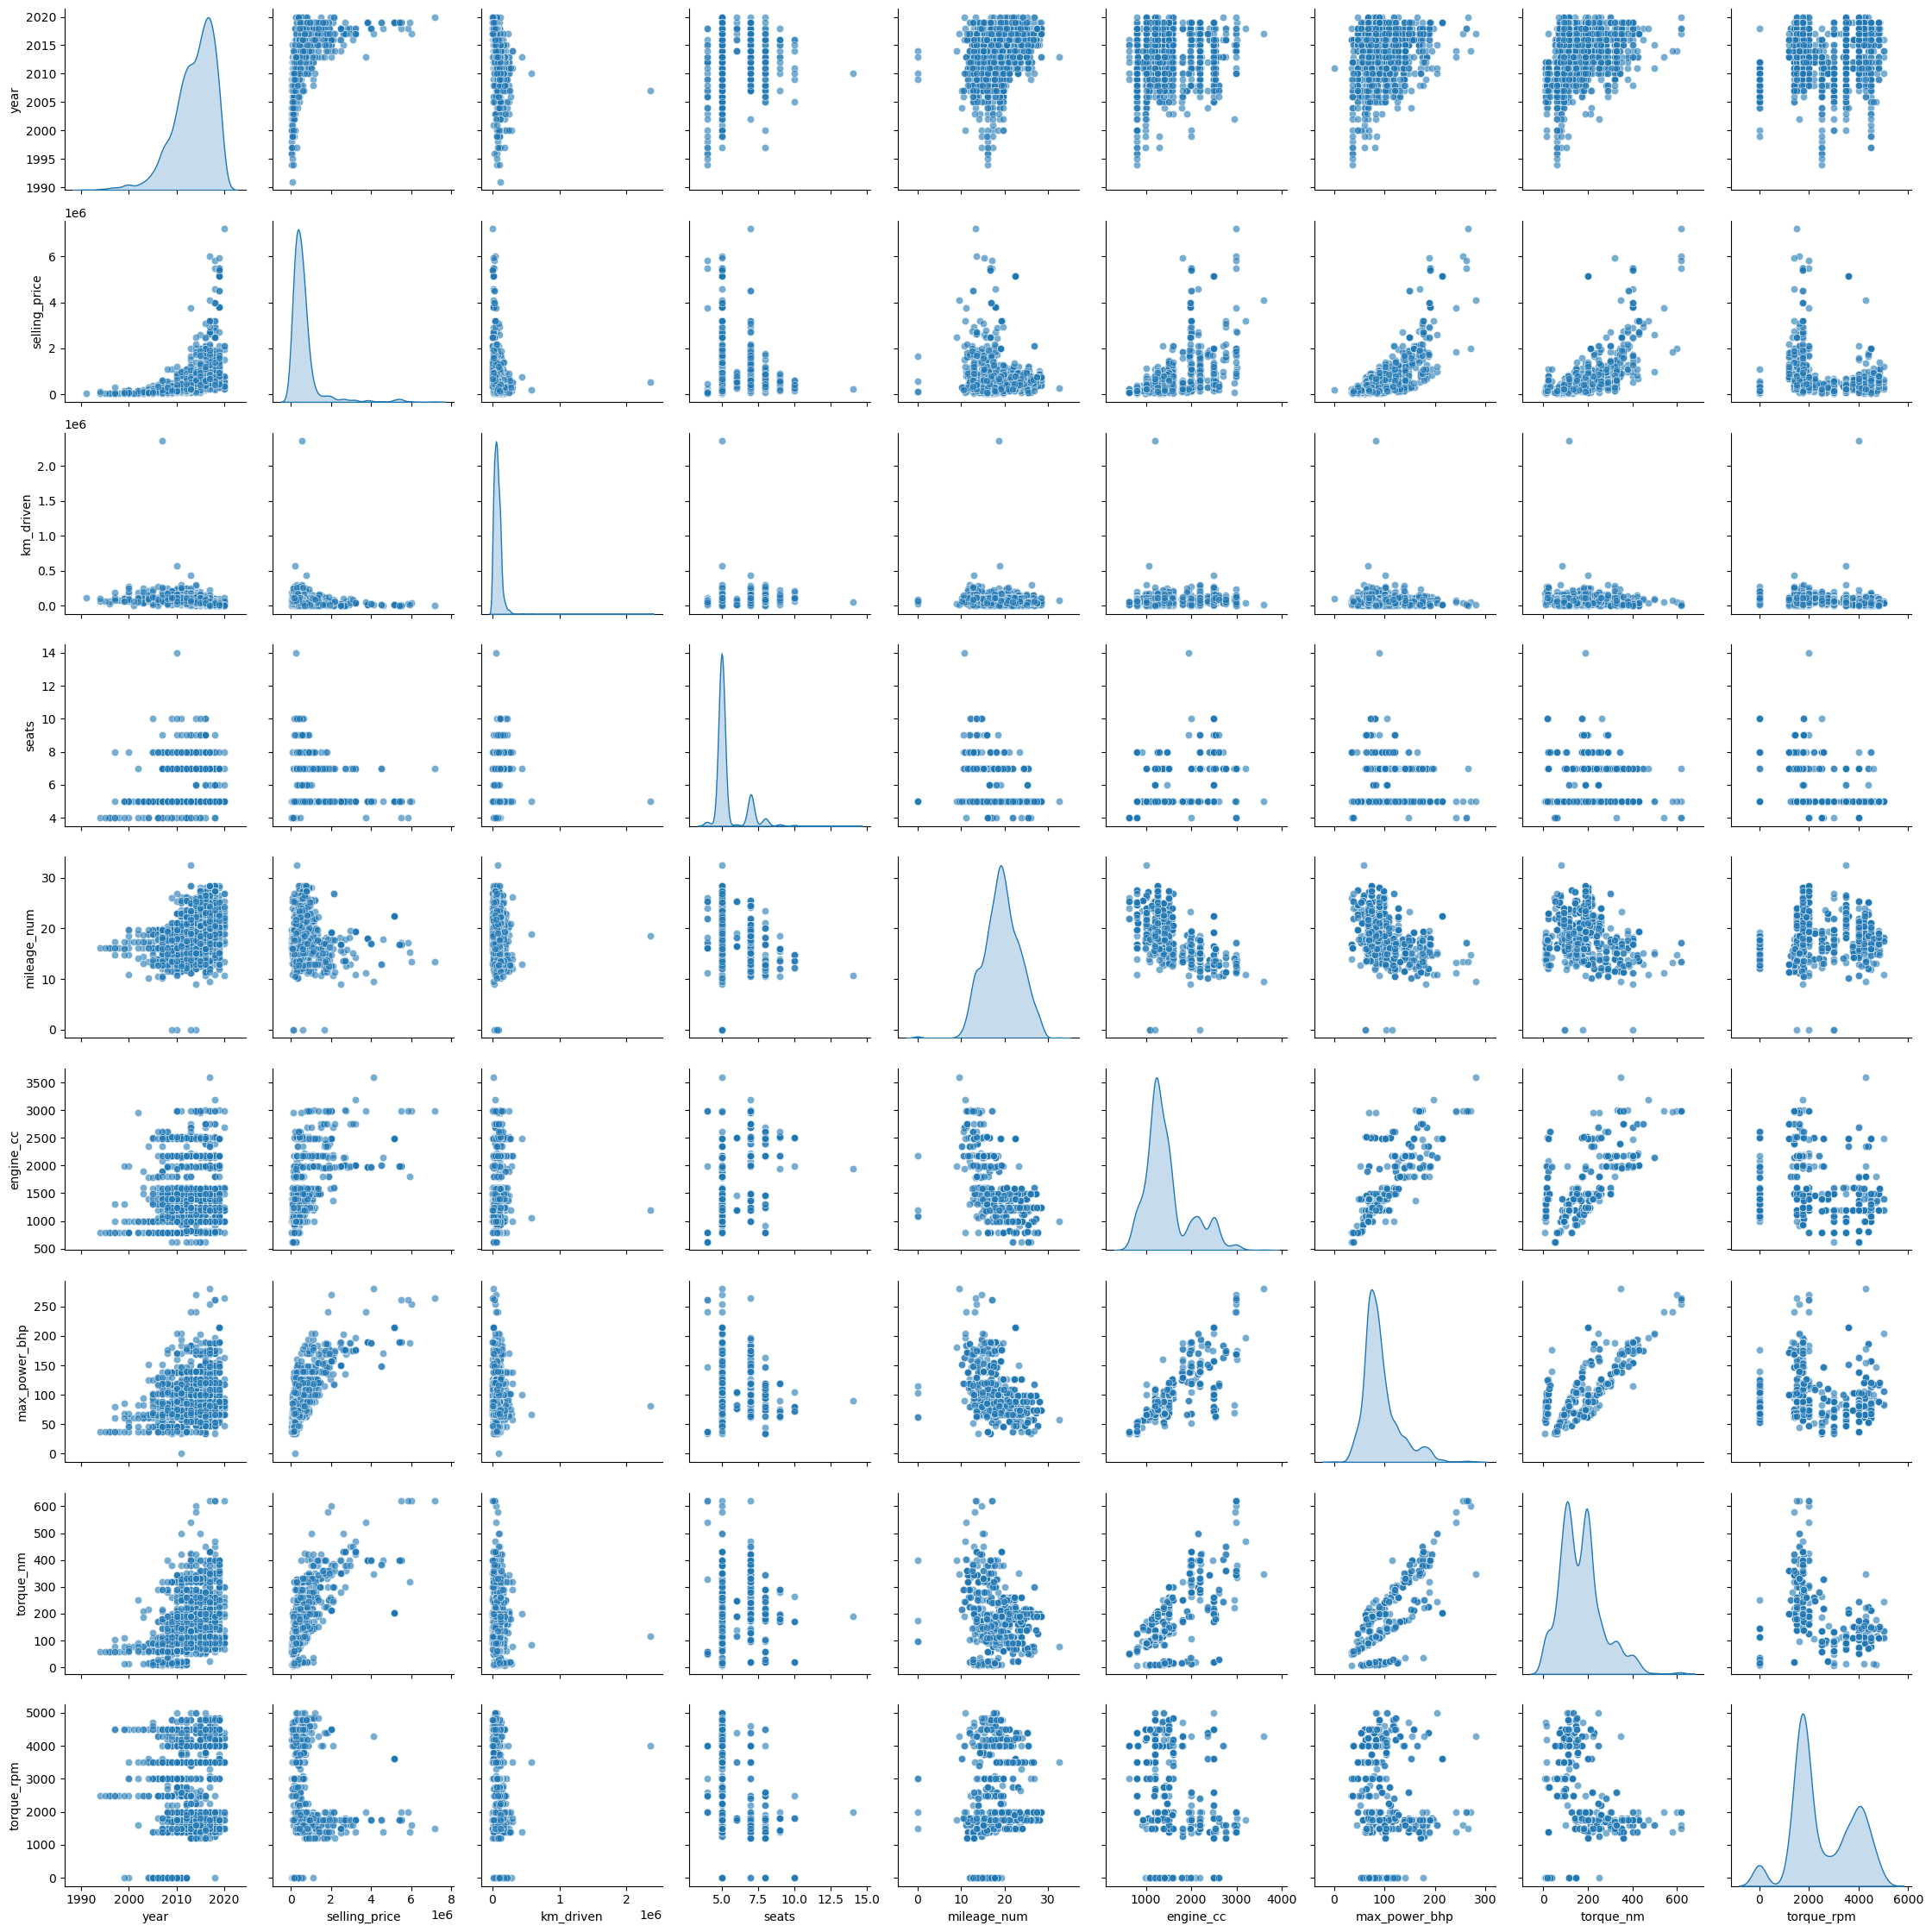

In [27]:
pairplot_analysis(df)

In [28]:
def time_series_analysis(df, time_col='year'):
    
    if time_col in df.columns:
        print(f"\nAnalyzing trends by {time_col}:")
        
        numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        numerical_cols = [col for col in numerical_cols if col != time_col]
        
        for col in numerical_cols:
            yearly_stats = df.groupby(time_col)[col].agg(['mean', 'median', 'count'])
            print(f"\n{col} by {time_col}:")
            print(yearly_stats)
            
            # Line plot
            plt.figure(figsize=(12, 6))
            yearly_stats['mean'].plot(marker='o', linewidth=2)
            plt.title(f'Average {col} by {time_col}')
            plt.xlabel(time_col)
            plt.ylabel(f'Average {col}')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()



Analyzing trends by year:

selling_price by year:
              mean    median  count
year                               
1983  3.000000e+05  300000.0      1
1991  5.500000e+04   55000.0      1
1994  8.800000e+04   99000.0      3
1995  1.075000e+05  107500.0      2
1996  8.166667e+04   42000.0      3
1997  9.018173e+04   57000.0     11
1998  7.310000e+04   63000.0     10
1999  7.583333e+04   70000.0     18
2000  9.304155e+04   83000.0     22
2001  4.849830e+04   45000.0     10
2002  9.899996e+04   75000.0     27
2003  9.563669e+04   70000.0     49
2004  1.109654e+05   90000.0     62
2005  1.411598e+05  110000.0     97
2006  1.639044e+05  140000.0    124
2007  1.777182e+05  150000.0    183
2008  2.074884e+05  170000.0    214
2009  2.264349e+05  180000.0    246
2010  2.726218e+05  220000.0    394
2011  3.237753e+05  270000.0    592
2012  3.511643e+05  300000.0    651
2013  4.600059e+05  387000.0    670
2014  5.161932e+05  450000.0    621
2015  5.966133e+05  525000.0    776
2016  6.99880

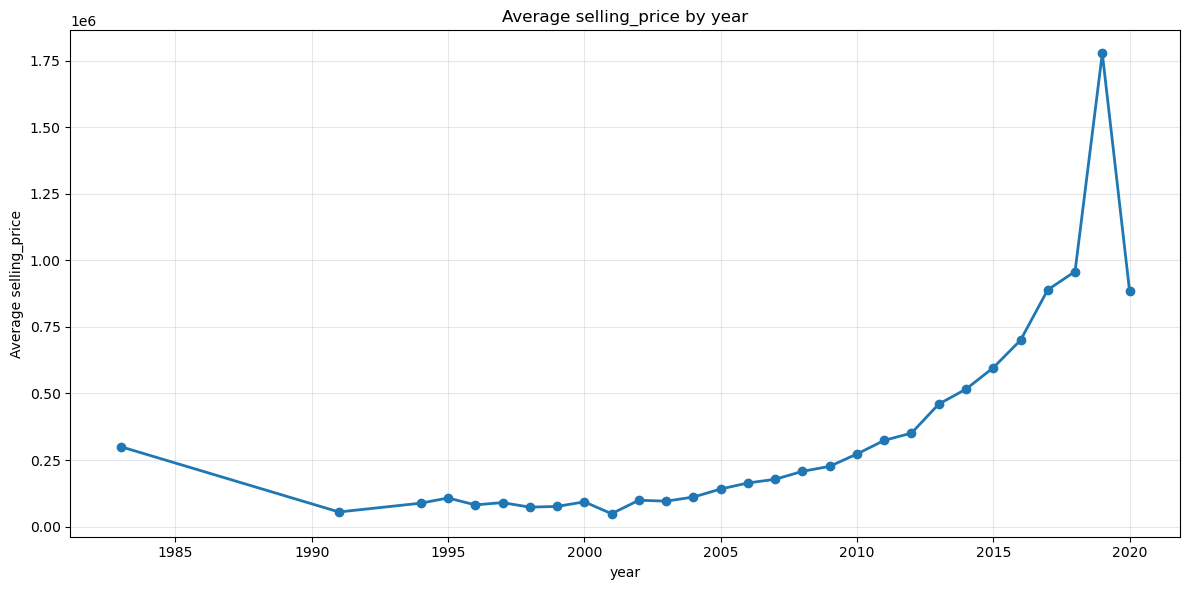


km_driven by year:
               mean    median  count
year                                
1983   10000.000000   10000.0      1
1991  120000.000000  120000.0      1
1994   86666.666667  100000.0      3
1995   80000.000000   80000.0      2
1996   35666.666667   32000.0      3
1997  100489.818182  100000.0     11
1998   68799.000000   70000.0     10
1999   93184.444444   90000.0     18
2000  106779.318182   90000.0     22
2001   58110.800000   65000.0     10
2002  102569.074074   80000.0     27
2003   92916.204082   80000.0     49
2004  100791.080645   94707.5     62
2005  100628.123711   90000.0     97
2006  104816.129032  100000.0    124
2007  113816.928962  100000.0    183
2008   97966.280374  100000.0    214
2009   98923.195122   90000.0    246
2010  101750.129442   90500.0    394
2011   96622.535473   89290.0    592
2012   95627.731183   90000.0    651
2013   85685.364179   79328.0    670
2014   78841.458937   72000.0    621
2015   71680.234536   63063.0    776
2016   58929.23515

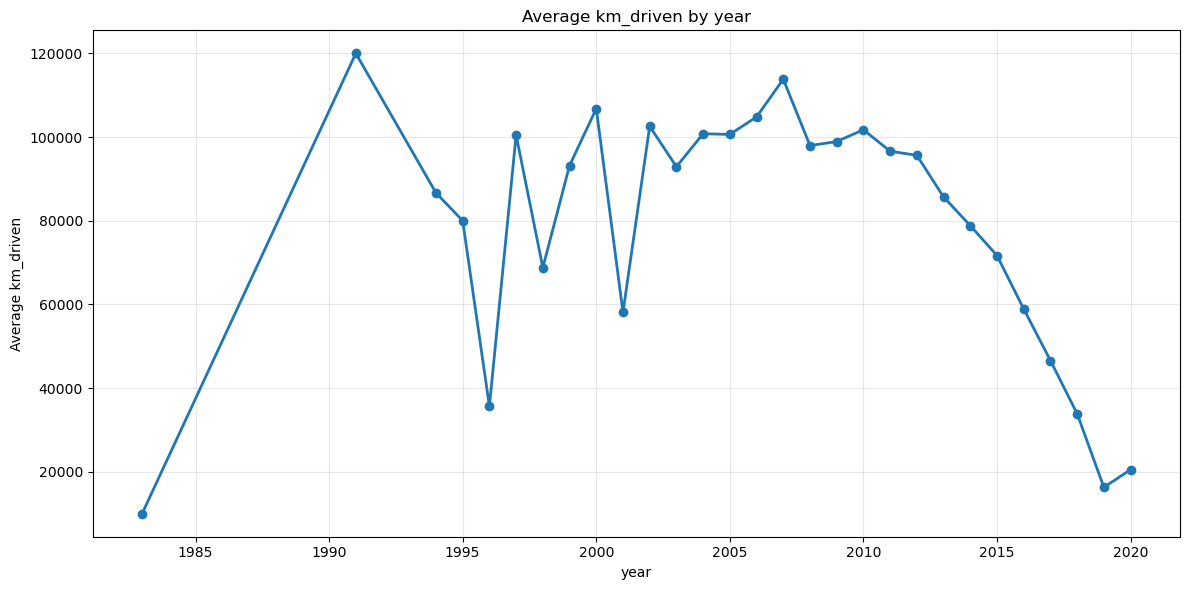


seats by year:
          mean  median  count
year                         
1983       NaN     NaN      0
1991       NaN     NaN      0
1994  4.500000     4.5      2
1995  4.000000     4.0      1
1996  4.000000     4.0      2
1997  4.666667     4.0      9
1998  4.555556     5.0      9
1999  4.500000     4.5     14
2000  5.187500     5.0     16
2001  4.333333     4.0      6
2002  5.210526     5.0     19
2003  5.081081     5.0     37
2004  4.862745     5.0     51
2005  5.394737     5.0     76
2006  5.431373     5.0    102
2007  5.381503     5.0    173
2008  5.492537     5.0    201
2009  5.367965     5.0    231
2010  5.416000     5.0    375
2011  5.445614     5.0    570
2012  5.431562     5.0    621
2013  5.600299     5.0    668
2014  5.601613     5.0    620
2015  5.598710     5.0    775
2016  5.463785     5.0    856
2017  5.312871     5.0   1010
2018  5.277916     5.0    806
2019  5.204117     5.0    583
2020  5.243243     5.0     74


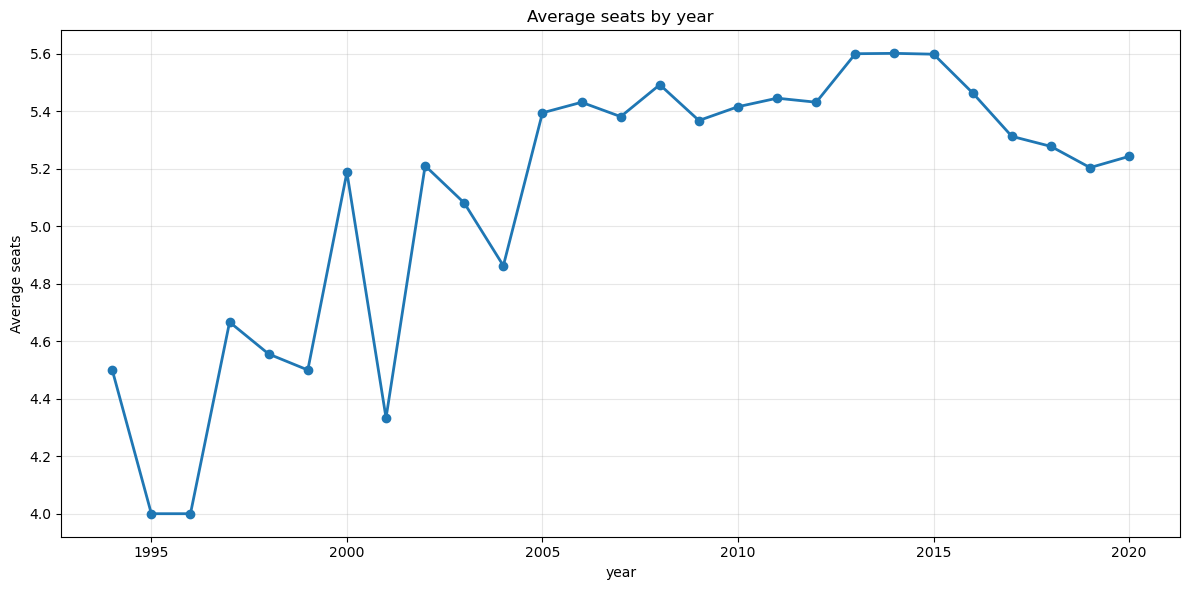


mileage_num by year:
           mean  median  count
year                          
1983        NaN     NaN      0
1991        NaN     NaN      0
1994  14.450000   14.45      2
1995  16.100000   16.10      1
1996  16.100000   16.10      2
1997  16.066667   16.10      9
1998  15.933333   16.10      9
1999  15.964286   16.10     14
2000  16.368750   16.10     16
2001  16.700000   16.10      6
2002  16.327895   16.10     19
2003  15.778378   16.10     37
2004  15.952941   16.10     51
2005  15.943421   16.10     76
2006  16.174020   16.80    102
2007  16.614277   17.20    173
2008  16.542637   17.50    201
2009  17.011126   17.80    231
2010  17.504453   18.00    375
2011  18.026281   18.60    570
2012  19.102206   19.40    621
2013  19.296243   20.36    668
2014  19.722645   20.36    620
2015  20.136452   20.45    775
2016  20.293014   20.14    856
2017  20.864713   21.04   1010
2018  21.024715   21.13    806
2019  19.918491   19.50    583
2020  19.833108   20.89     74


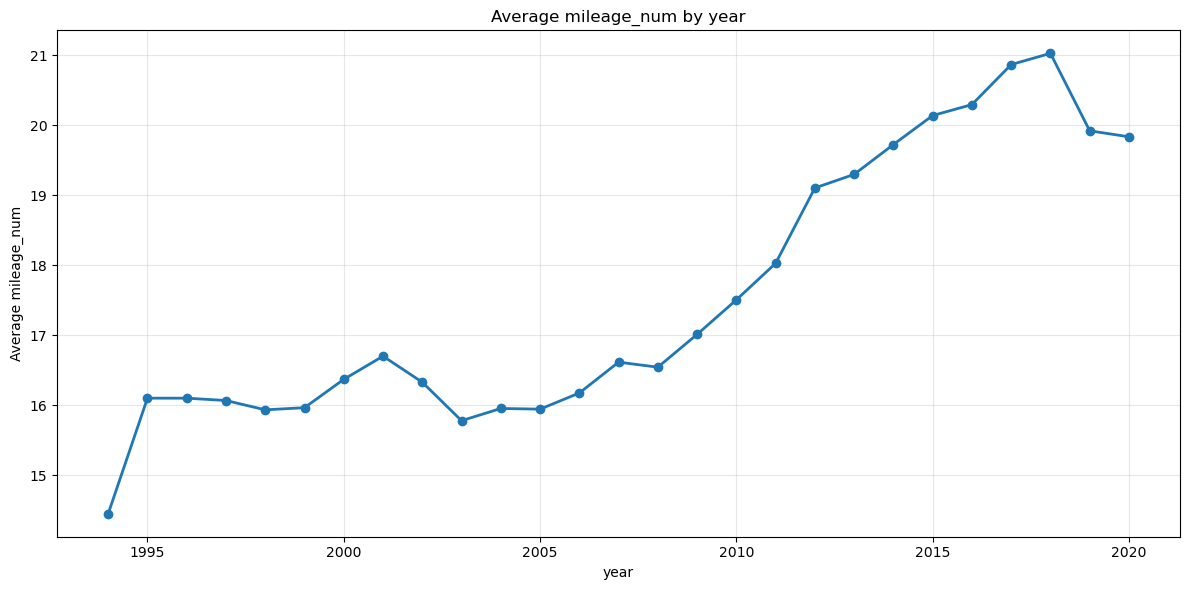


engine_cc by year:
             mean  median  count
year                            
1983          NaN     NaN      0
1991          NaN     NaN      0
1994  1395.500000  1395.5      2
1995   796.000000   796.0      1
1996   796.000000   796.0      2
1997   929.444444   796.0      9
1998   950.777778   796.0      9
1999  1153.428571   894.5     14
2000  1011.062500   796.0     16
2001   828.833333   796.0      6
2002  1187.000000   993.0     19
2003  1302.675676   998.0     37
2004  1252.490196   998.0     51
2005  1421.947368  1341.0     76
2006  1456.656863  1405.0    102
2007  1461.387283  1396.0    173
2008  1472.636816  1396.0    201
2009  1420.930736  1248.0    231
2010  1436.133333  1248.0    375
2011  1531.138596  1397.5    570
2012  1465.280193  1396.0    621
2013  1528.327844  1392.0    668
2014  1517.109677  1364.0    620
2015  1494.689032  1373.0    775
2016  1434.808411  1248.0    856
2017  1419.234653  1248.0   1010
2018  1404.681141  1248.0    806
2019  1492.324185  1199

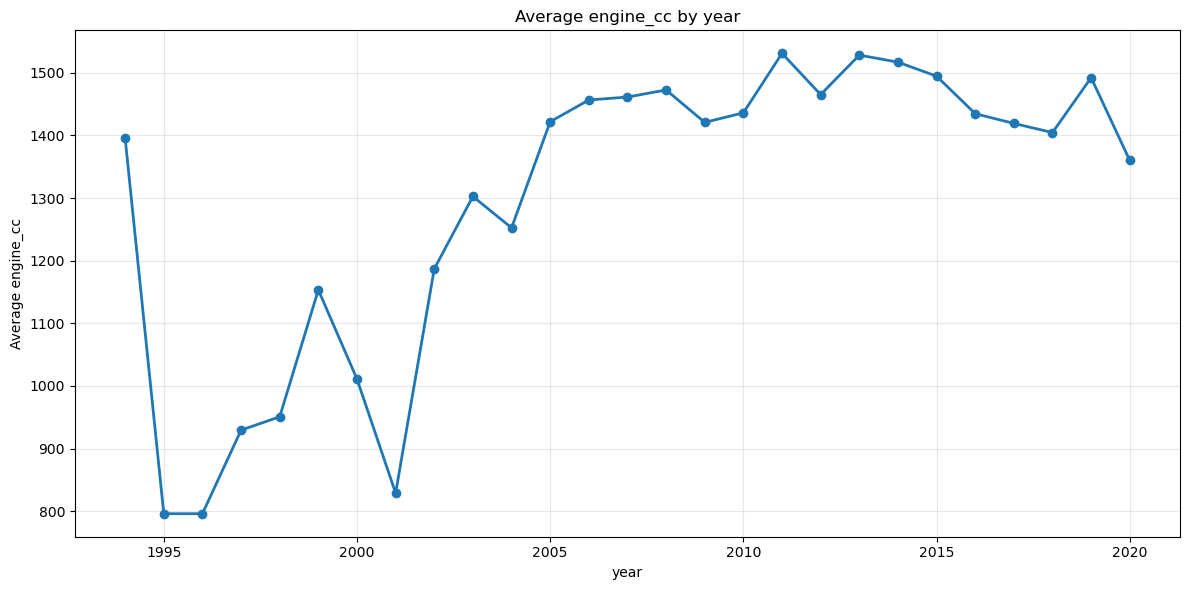


max_power_bhp by year:
            mean  median  count
year                           
1983         NaN     NaN      0
1991         NaN     NaN      0
1994   44.500000  44.500      2
1995   37.000000  37.000      1
1996   37.000000  37.000      2
1997   49.666667  37.000      9
1998   48.888889  37.000      9
1999   53.785714  48.500     14
2000   48.093333  46.300     15
2001   43.500000  37.000      6
2002   58.515789  60.000     19
2003   68.829730  66.000     37
2004   70.956863  62.000     51
2005   77.257895  69.000     76
2006   80.700980  74.000    102
2007   78.251387  67.000    173
2008   81.149950  70.000    201
2009   83.308139  73.900    231
2010   85.013573  75.000    375
2011   87.576434  75.000    572
2012   86.259005  78.000    623
2013   88.651108  80.900    668
2014   89.951871  82.000    620
2015   92.668852  88.500    775
2016   92.549562  88.500    856
2017   97.084970  86.745   1012
2018   95.964529  84.000    806
2019  114.106930  88.700    583
2020   93.640135

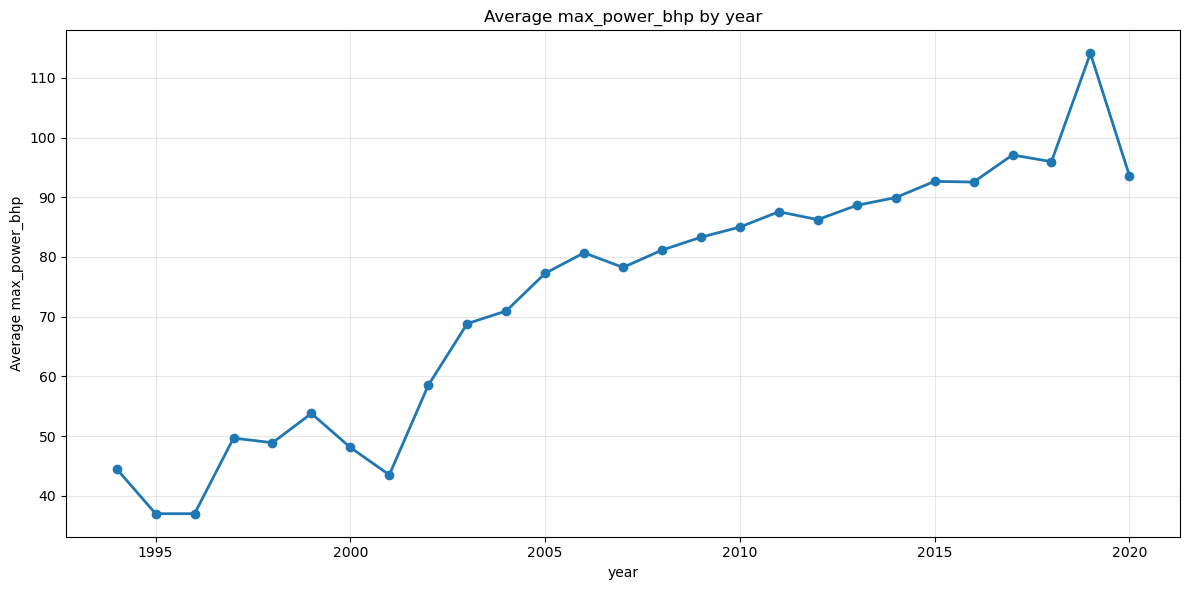


torque_nm by year:
            mean  median  count
year                           
1983         NaN     NaN      0
1991         NaN     NaN      0
1994   82.500000   82.50      2
1995   59.000000   59.00      1
1996   59.000000   59.00      2
1997   71.666667   59.00      9
1998   66.344444   59.00      9
1999   59.035714   59.00     14
2000   58.426667   62.00     15
2001   64.166667   59.00      6
2002  115.715789   62.00     19
2003  115.908108   78.00     37
2004   74.284314   59.00     51
2005   81.931579   62.00     76
2006   74.576471   59.00    102
2007   83.514335   62.00    173
2008   95.944179   84.00    201
2009  120.586667   99.04    231
2010  127.309013  110.00    375
2011  156.955544  145.00    570
2012  166.619163  160.00    621
2013  182.045554  190.00    668
2014  186.246903  190.00    620
2015  186.209923  190.00    775
2016  174.057056  173.75    856
2017  192.094980  190.00   1010
2018  184.826911  170.00    806
2019  197.050137  142.00    583
2020  165.353649  11

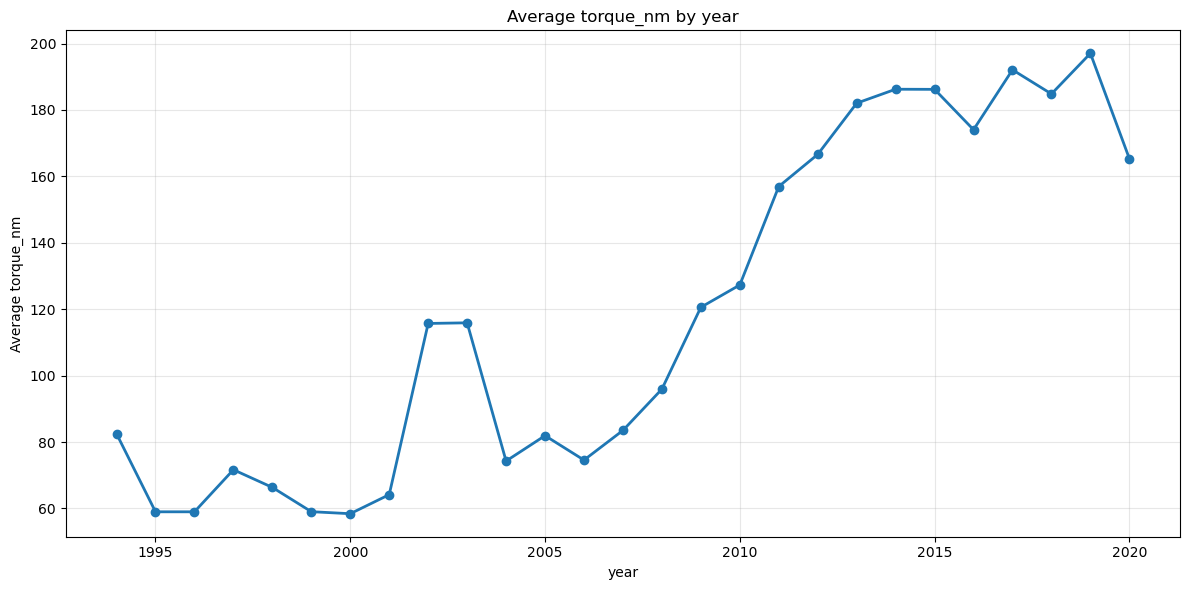


torque_rpm by year:
             mean  median  count
year                            
1983          NaN     NaN      0
1991          NaN     NaN      0
1994  2350.000000  2350.0      2
1995  2500.000000  2500.0      1
1996  2500.000000  2500.0      2
1997  3166.666667  2500.0      9
1998  3255.555556  2800.0      9
1999  2536.357143  2500.0     14
2000  2816.866667  2500.0     15
2001  3000.000000  2500.0      6
2002  3044.894737  2500.0     19
2003  2476.750000  2500.0     36
2004  2565.156863  2500.0     51
2005  2454.671053  3000.0     76
2006  1678.792079  1700.0    101
2007  1696.458824  1700.0    170
2008  1837.800000  1900.0    200
2009  2553.571429  2750.0    231
2010  2594.034759  2750.0    374
2011  2454.680702  2000.0    570
2012  2471.716586  2000.0    621
2013  2372.878743  2000.0    668
2014  2448.774194  2000.0    620
2015  2518.033548  1900.0    775
2016  2857.695093  2500.0    856
2017  2638.899010  2000.0   1010
2018  2770.019925  2000.0    803
2019  3154.192029  360

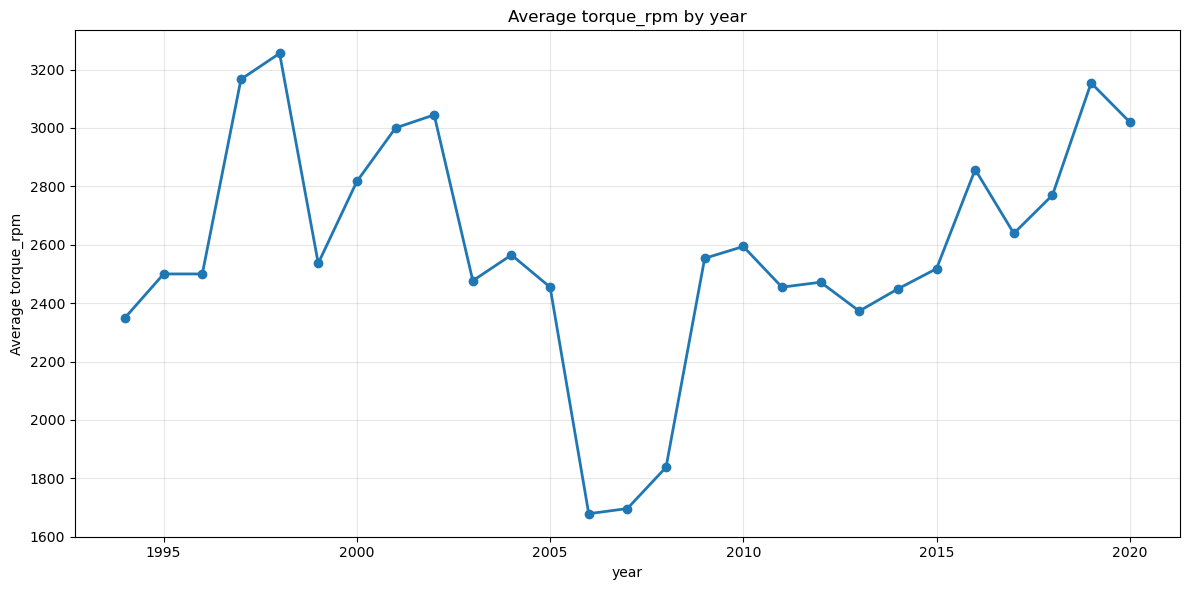

In [29]:
time_series_analysis(df)

1. Average Selling Price by Year

- Overall Trend: Dramatic exponential increase from 2010 onwards
- 1983-2010: Relatively flat, ranging from ~50K to 250K
- 2010-2019: Steady upward climb from 250K to ~1M
- 2019-2020: Massive spike to 1.75M (likely luxury/premium cars entering the market)
- 2020-2021: Sharp drop back to ~900K
**Interpretation:** Recent years show much higher car prices, possibly due to inflation, luxury segment growth, or currency effects

2. Average KM Driven by Year
- Highly volatile pattern with significant fluctuations
- Peak at 1991: ~120K km (older cars had more usage)
- 1996 dip: Drops to ~36K km
- 2000-2010: Fluctuates between 60K-115K km
- 2010-2020: Clear downward trend from 100K to ~20K km
**Interpretation:** Newer cars in the dataset have driven fewer kilometers (they're newer/less used)

3. Average Seats by Year
- Range: 4-5.6 seats across all years
- 990s: More variation (4-5.2 seats)
- 2005-2015: Stabilized around 5.4-5.6 seats (peak SUV/family car popularity)
- 2015-2020: Slight decline to ~5.2 seats
**Interpretation:** Shift toward larger vehicles (SUVs, MPVs) in 2000s-2010s, then slight return to smaller cars

4. Average Mileage (Fuel Efficiency) by Year
- Strong upward trend from 1994 onwards
- 1994: ~14.5 km/L
- 2018: Peak at ~21 km/L (45% improvement!)
- 2018-2021: Slight decline to ~20 km/L
**Interpretation:** Clear technological improvement in fuel efficiency due to better engines, aerodynamics, and hybrid technology

5. Average Engine CC by Year

- Highly variable with no clear linear trend
- 1994: 1,400 cc
- 1995-1997: Sharp drop to ~800 cc (small car boom)
- 2005-2013: Rises to 1,400-1,550 cc (larger engines)
- 2020-2021: Drops to ~1,360 cc
**Interpretation:** Market shifts between small economy cars and larger performance vehicles

6. Average Max Power (BHP) by Year

- Strong upward trend indicating more powerful engines
- 1994: ~45 BHP
- 2019: Peak at ~114 BHP (2.5x increase!)
- 2000s: Acceleration in power increase begins
**Interpretation:** Consumer demand for performance; turbocharged engines became common

7. Average Torque (Nm) by Year

- Dramatic upward trend especially after 2008
- 1994: ~82 Nm
- 2019: ~197 Nm (2.4x increase!)
- 2008-2019: Steepest increase period
**Interpretation:** Better engine technology (turbocharging, diesel engines) providing more low-end power

8. Average Torque RPM by Year

- Most volatile graph with major fluctuations
- 1998-1999: Peak at ~3,250 RPM
- 2006-2007: Dramatic drop to ~1,700 RPM (diesel engine adoption?)
- 2019: Returns to ~3,150 RPM
**Interpretation:** Lower RPM = torque available earlier (diesel characteristic); recent rise suggests petrol/hybrid shift

In [33]:
target = df['selling_price']

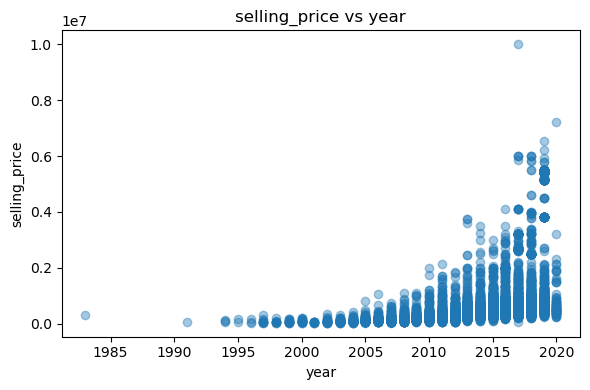

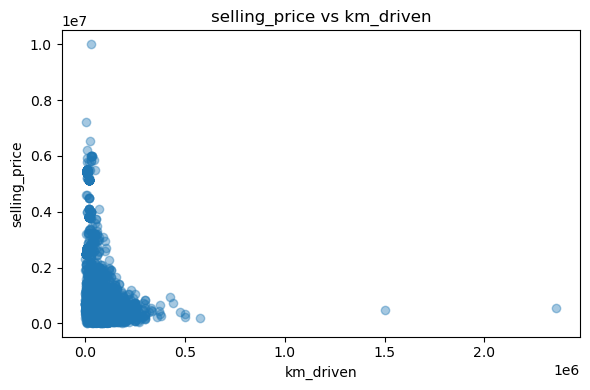

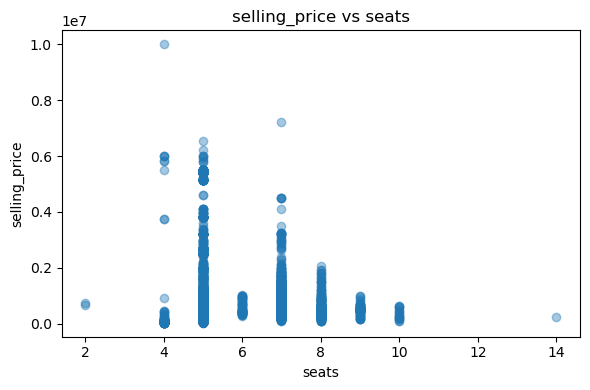

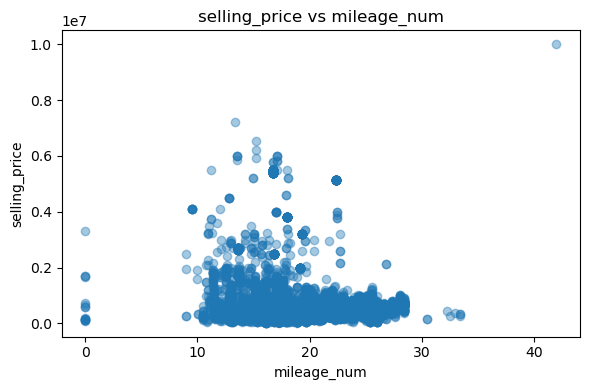

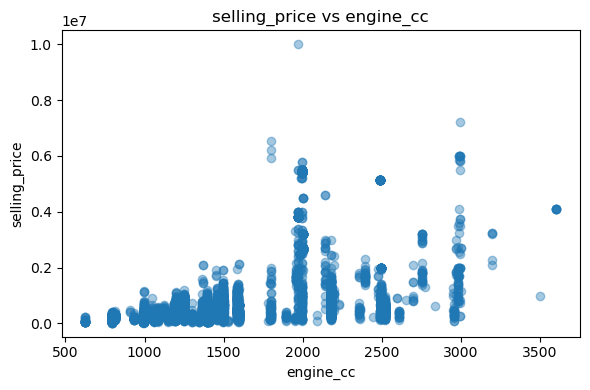

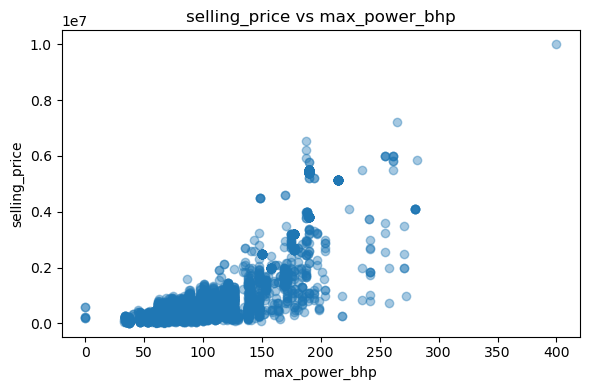

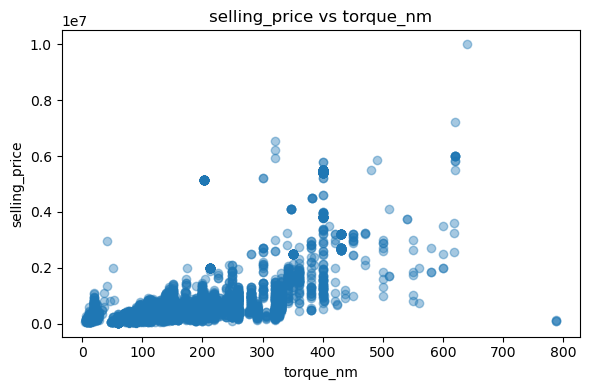

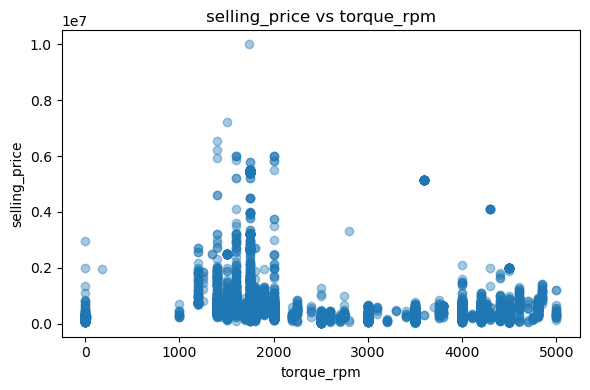

C:\Users\Laiba\AppData\Local\Temp\ipykernel_29692\4239846875.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=[str(k) for k in top], showfliers=False)


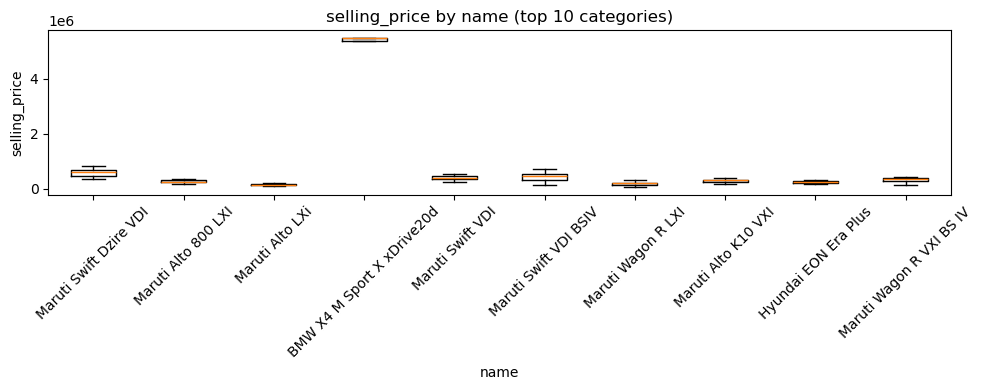

C:\Users\Laiba\AppData\Local\Temp\ipykernel_29692\4239846875.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=[str(k) for k in top], showfliers=False)


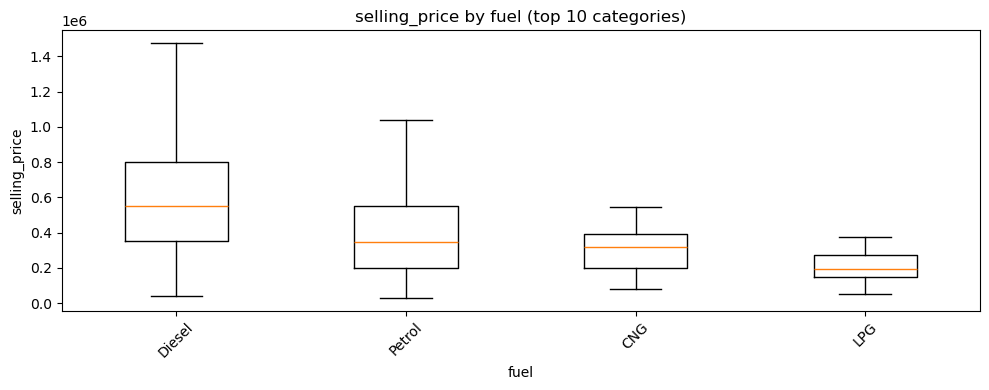

C:\Users\Laiba\AppData\Local\Temp\ipykernel_29692\4239846875.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=[str(k) for k in top], showfliers=False)


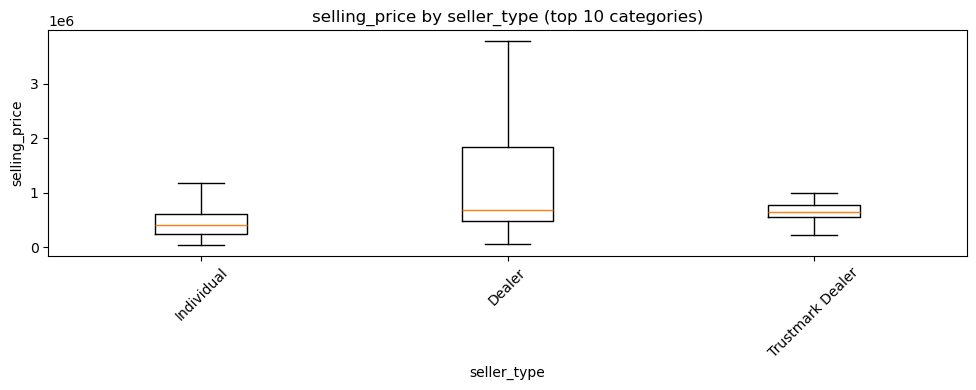

C:\Users\Laiba\AppData\Local\Temp\ipykernel_29692\4239846875.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=[str(k) for k in top], showfliers=False)


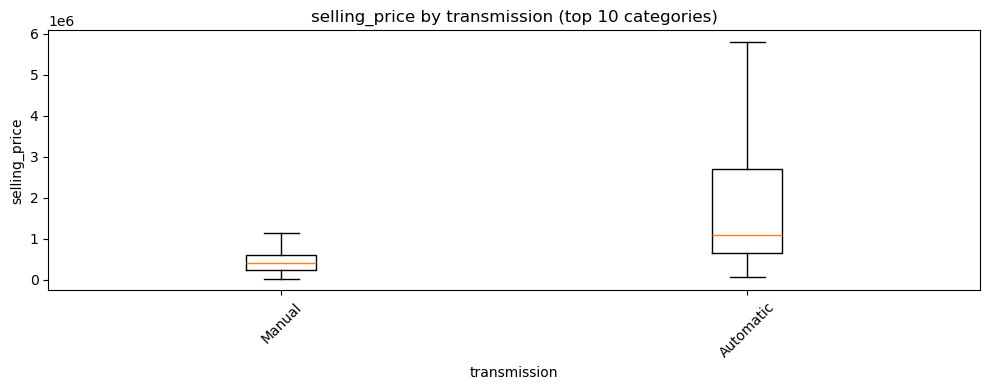

C:\Users\Laiba\AppData\Local\Temp\ipykernel_29692\4239846875.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=[str(k) for k in top], showfliers=False)


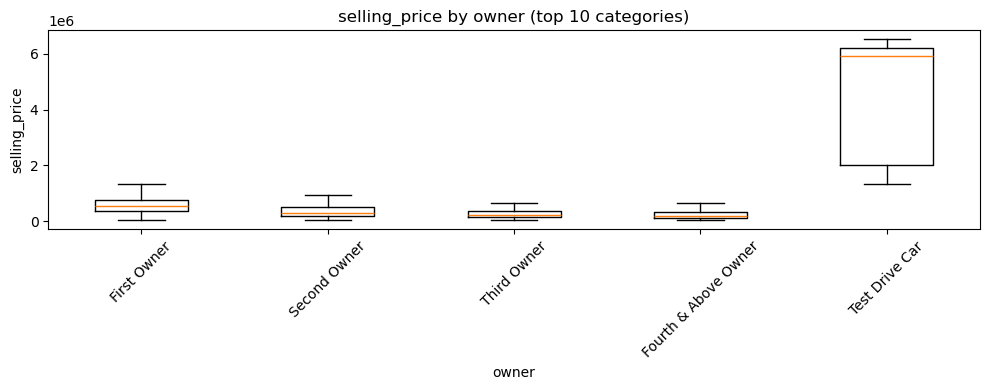

In [35]:
# ensure target_col is a column name (string)
if isinstance(target, pd.Series):
    target_col = target.name
else:
    target_col = target

if target_col in df.columns:
    # numeric columns excluding target
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != target_col]
    # categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Target vs numeric features (scatter)
    for col in num_cols:
        tmp = df[[col, target_col]].dropna()
        if tmp.empty:
            continue
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(tmp[col], tmp[target_col], alpha=0.4)
        ax.set_title(f"{target_col} vs {col}")
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)
        plt.tight_layout()
        plt.show()

    # Target vs categorical features (box via grouped data)
    for col in cat_cols:
        # limit to top categories to avoid unreadable plots
        top = df[col].value_counts().head(10).index
        tmp = df[df[col].isin(top)][[col, target_col]].dropna()
        if tmp.empty:
            continue

        groups = [tmp.loc[tmp[col] == k, target_col].values for k in top]
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.boxplot(groups, labels=[str(k) for k in top], showfliers=False)
        ax.set_title(f"{target_col} by {col} (top 10 categories)")
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)
        ax.tick_params(axis="x", rotation=45)
        plt.tight_layout()
        plt.show()
